In [4]:
# Load selected variables from tensors.pkl with the same variable names
import os
import pickle

FNAME = "tensors.pkl"
NEEDED_KEYS = [
    "mat_100pp_spikefiltered",
    "mat_100hp_spikefiltered",
    "event_intervals_ms",
    "lwhl",
    "event_arm_ids",
    "event_arm_ids_rewarded",
]

if not os.path.exists(FNAME):
    raise FileNotFoundError(f"File not found: {FNAME}")

with open(FNAME, "rb") as f:
    data = pickle.load(f)

if not isinstance(data, dict):
    raise ValueError("Pickle content is not a dict of named objects.")

missing = []
for k in NEEDED_KEYS:
    if k in data:
        globals()[k] = data[k]
    else:
        globals()[k] = None
        missing.append(k)

# Brief summary
def _brief(v):
    t = type(v).__name__
    extra = ""
    try:
        if hasattr(v, "shape") and getattr(v, "shape") is not None:
            extra = f" | shape={v.shape}"
        elif hasattr(v, "__len__") and not isinstance(v, (str, bytes)):
            extra = f" | len={len(v)}"
    except Exception:
        pass
    return f"{t}{extra}"

print(f"Loaded from {FNAME}:")
for k in NEEDED_KEYS:
    print(f"  • {k}: {_brief(globals()[k])}")

if missing:
    print("\n[warning] Missing key(s) in pickle:", ", ".join(missing))

Loaded from tensors.pkl:
  • mat_100pp_spikefiltered: ndarray | shape=(399, 75707)
  • mat_100hp_spikefiltered: ndarray | shape=(40, 75707)
  • event_intervals_ms: list | len=180
  • lwhl: DataFrame | shape=(295727, 7)
  • event_arm_ids: list | len=180
  • event_arm_ids_rewarded: ndarray | shape=(133,)


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import List, Tuple, Optional

# time-index helper
def _infer_time_ms_from_index(index, fs_hz: float = 39.0625) -> np.ndarray:
    """
    Convert a pandas Index to milliseconds relative to its first sample.
    Supports DatetimeIndex, numeric seconds/ms, or sample indices.
    """
    if isinstance(index, pd.DatetimeIndex):
        t0 = index[0]
        return ((index - t0) / pd.Timedelta(milliseconds=1)).astype(float)

    idx = np.asarray(index, dtype=float)
    if idx.ndim != 1 or len(idx) < 2:
        raise ValueError("Index must be 1D with at least 2 points.")
    d = float(np.median(np.diff(idx)))

    dt_s  = 1.0 / fs_hz          # ~0.0256 s
    dt_ms = 1000.0 / fs_hz       # ~25.6 ms

    if abs(d - dt_s) < 1e-3:     # seconds at given fs
        return (idx - idx[0]) * 1000.0
    if abs(d - dt_ms) < 1.0:     # milliseconds
        return (idx - idx[0])
    if abs(d - 1.0) < 0.1:       # sample indices
        return (idx - idx[0]) * dt_ms
    return (idx - idx[0]) * 1000.0  # fallback: seconds


# helper to convert (neurons, time, n_events) → list of 2D matrices per event
def tensor_to_event_mats(tensor_ntu, kept_mask=None):
    """
    Convert a 3D tensor (neurons, time_bins, n_events) into a list of matrices
    [ (neurons x time_bins) for each kept event ] for the RF block-CV helper.
    """
    if kept_mask is None:
        kept_mask = np.ones(tensor_ntu.shape[2], dtype=bool)
    idx = np.where(kept_mask)[0]
    return [tensor_ntu[:, :, k] for k in idx]


#  Neural pre-entry extractor 
def extract_preentry_tensor_binned(neural_binned: np.ndarray, event_intervals_ms: List[Tuple[float, float]], *,
    bin_size_ms: float = 100.0, pre_ms: float = 2000.0, session_start_ms: float = 0.0,
    on_short: str = "drop",      # "drop" or "pad"
    pad_value: float = 0.0,) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Build a tensor of neural activity for the pre-entry window before each event.
    Assumes `neural_binned` is already time-binned at `bin_size_ms`.

    Assumptions
    -----------
    Column i of `neural_binned` corresponds to time range:
        [session_start_ms + i*bin_size_ms, session_start_ms + (i+1)*bin_size_ms)

    For each event (start_ms, end_ms), we take the T bins immediately preceding start_ms:
        T = round(pre_ms / bin_size_ms)
        end_bin_exclusive = floor((start_ms - session_start_ms) / bin_size_ms)
        window bins = [end_bin_exclusive - T, ..., end_bin_exclusive - 1]

    Parameters
    ----------
    neural_binned : np.ndarray
        Shape (n_neurons, T_session_bins).
    event_intervals_ms : list of (start_ms, end_ms)
        Event list (only start_ms is used).
    bin_size_ms : float
        Size of each time bin in neural_binned (default 100 ms).
    pre_ms : float
        Length of the pre-entry window in milliseconds (default 2000 ms).
    session_start_ms : float
        Offset for the time zero relative to the neural matrix column 0 (default 0).
    on_short : {"drop","pad"}
        What to do if the window would extend before column 0.
        - "drop": skip that event
        - "pad" : left-pad with `pad_value` to keep T bins
    pad_value : float
        Value used if on_short="pad".

    Returns
    -------
    tensor : np.ndarray
        Shape (n_neurons, T_bins, n_events_kept) with the pre-entry activity.
    kept_mask : np.ndarray (bool)
        Mask (len = n_events_input) indicating which events were included.
    t_rel_ms : np.ndarray
        Relative time (ms) for bin centers: e.g., [-1950, -1850, ..., -50] for 100 ms bins.
    """
    if neural_binned.ndim != 2:
        raise ValueError("neural_binned must be 2D (n_neurons, T_session_bins).")
    n_neurons, T_session = neural_binned.shape
    if n_neurons < 1 or T_session < 1:
        raise ValueError("neural_binned has invalid shape.")

    T_bins = int(round(pre_ms / float(bin_size_ms)))
    if T_bins < 1:
        raise ValueError("pre_ms/bin_size_ms must be >= 1 bin.")

    # Bin centers relative to event start: [-pre_ms + bin/2, ..., -bin/2]
    t_rel_ms = (np.arange(T_bins) + 0.5) * bin_size_ms - pre_ms

    kept_mask = []
    slices = []  # will collect (n_neurons, T_bins) per kept event

    for (start_ms, end_ms) in event_intervals_ms:
        # index of the first bin whose START time is at/after start_ms
        end_bin_excl = int(np.floor((start_ms - session_start_ms) / float(bin_size_ms)))
        start_bin = end_bin_excl - T_bins
        end_bin   = end_bin_excl  # exclusive

        if start_bin < 0:
            if on_short == "drop":
                kept_mask.append(False)
                continue
            elif on_short == "pad":
                n_missing = -start_bin
                # take [0 : end_bin) and left-pad
                if end_bin <= 0:
                    # entire window before session start; pad everything
                    seg = np.full((n_neurons, T_bins), pad_value, dtype=float)
                else:
                    take = min(T_bins - n_missing, end_bin)
                    seg = np.full((n_neurons, T_bins), pad_value, dtype=float)
                    seg[:, n_missing : n_missing + take] = neural_binned[:, 0:take]
                slices.append(seg)
                kept_mask.append(True)
                continue
            else:
                raise ValueError("on_short must be 'drop' or 'pad'.")

        if end_bin > T_session:
            # If event starts after session bounds, drop
            kept_mask.append(False)
            continue

        # Normal inside-bounds slice [start_bin : end_bin)
        seg = neural_binned[:, start_bin:end_bin]
        if seg.shape[1] != T_bins:
            # guard against off-by-one from rounding
            if seg.shape[1] < T_bins and on_short == "pad":
                pad = np.full((n_neurons, T_bins - seg.shape[1]), pad_value, dtype=float)
                seg = np.concatenate([pad, seg], axis=1)  # left-pad
            else:
                # drop inconsistent windows
                kept_mask.append(False)
                continue

        slices.append(seg.astype(float, copy=False))
        kept_mask.append(True)

    kept_mask = np.asarray(kept_mask, dtype=bool)
    if slices:
        tensor = np.stack(slices, axis=-1)  # (neurons, T_bins, n_kept)
    else:
        tensor = np.empty((n_neurons, T_bins, 0), dtype=float)
    return tensor, kept_mask, t_rel_ms


# Plot pre-entry trajectories from lwhl 
def plot_preentry_trajectories_from_whl(lwhl: pd.DataFrame,
    event_intervals_ms: List[Tuple[float, float]], *, pre_ms: float = 2000.0, fs_hz: float = 39.0625,
    kept_mask: Optional[np.ndarray] = None, arm_ids: Optional[np.ndarray] = None,
    cmap = plt.cm.tab10, alpha: float = 0.5, linewidth: float = 1.5,
    center: Optional[Tuple[float, float]] = None, title: Optional[str] = "Pre-entry trajectories"):
    """
    Plot the 2 s (or pre_ms) position trajectories before each event start.
    Accepts `kept_mask` (from the neural extractor) to plot only matched events.

    Parameters
    ----------
    lwhl : DataFrame with columns ['x1','y1']; index is time (DatetimeIndex, seconds, ms, or sample idx).
    event_intervals_ms : list of (start_ms, end_ms)
    pre_ms : float
        Length in ms of the trajectory segment before event start.
    fs_hz : float
        Tracking sampling rate (used for index inference).
    kept_mask : np.ndarray | None
        If provided, only trajectories with kept_mask==True will be plotted (must match len(events)).
    arm_ids : array-like | None
        If provided, used to color trajectories by arm; values are mapped to cmap.
    cmap : matplotlib colormap
    alpha, linewidth : aesthetics
    center : (x0, y0) | None
        If provided, plot x-x0, y-y0 (centered coordinates).
    title : str | None
        Figure title.

    Returns
    -------
    fig, ax, traj_kept_mask
    """
    if not {"x1","y1"}.issubset(lwhl.columns):
        raise ValueError("lwhl must contain 'x1' and 'y1' columns.")
    lwhl = lwhl.sort_index()
    lwhl = lwhl[~lwhl.index.duplicated(keep="first")]

    x = lwhl["x1"].astype(float).copy()
    y = lwhl["y1"].astype(float).copy()
    # simple sanitization
    x.replace([np.inf, -np.inf], np.nan, inplace=True)
    y.replace([np.inf, -np.inf], np.nan, inplace=True)
    x = x.interpolate(method="time") if isinstance(x.index, pd.DatetimeIndex) else x.interpolate()
    y = y.interpolate(method="time") if isinstance(y.index, pd.DatetimeIndex) else y.interpolate()
    x = x.ffill().bfill().fillna(0.0)
    y = y.ffill().bfill().fillna(0.0)

    if center is not None:
        x = x - float(center[0])
        y = y - float(center[1])

    t_ms = _infer_time_ms_from_index(x.index, fs_hz=fs_hz).astype(float)
    t0, t1 = float(t_ms[0]), float(t_ms[-1])

    # If a kept_mask is given, filter the events accordingly for plotting
    events = event_intervals_ms
    if kept_mask is not None:
        if len(kept_mask) != len(events):
            raise ValueError("kept_mask length must match number of events.")
        events = [ev for ev, k in zip(events, kept_mask) if k]
        arm_ids_plot = None if arm_ids is None else np.asarray(arm_ids)[kept_mask]
    else:
        arm_ids_plot = None if arm_ids is None else np.asarray(arm_ids)

    fig, ax = plt.subplots(figsize=(6, 6))
    # build a color map for arm ids if provided
    color_map = {}
    if arm_ids_plot is not None:
        uniq = list(dict.fromkeys(arm_ids_plot.tolist()))  # preserve order
        for i, a in enumerate(uniq):
            color_map[a] = cmap(i % 10)

    plotted_mask = []

    for idx, (start_ms, end_ms) in enumerate(events):
        s = float(start_ms) - float(pre_ms)
        e = float(start_ms)
        if e <= s:
            plotted_mask.append(False)
            continue
        # clip to whl coverage
        s = max(s, t0); e = min(e, t1)
        if e - s <= 0:
            plotted_mask.append(False)
            continue

        # indices into whl
        m = (t_ms >= s) & (t_ms <= e)
        if not np.any(m):
            plotted_mask.append(False)
            continue

        xi = x.values[m]
        yi = y.values[m]
        if len(xi) < 2:
            plotted_mask.append(False)
            continue

        col = color_map[arm_ids_plot[idx]] if arm_ids_plot is not None else (0, 0, 0, 1)
        ax.plot(xi, yi, '-', alpha=alpha, lw=linewidth, color=col)
        ax.plot(xi[-1], yi[-1], 'o', ms=3, color=col, alpha=min(1.0, alpha+0.2))  # mark entry point
        plotted_mask.append(True)

    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_aspect('equal')
    if title:
        ax.set_title(title)
    ax.grid(True, ls='--', alpha=0.2)

    return fig, ax, np.asarray(plotted_mask, dtype=bool)

pre-entry tensor shape: (399, 20, 179)


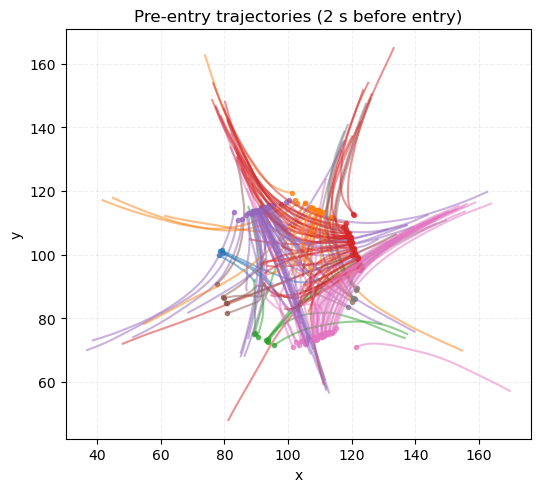

In [6]:
# 1) Build the neural pre-entry tensor (2 s, 100 ms bins by default)
tensor_pre, kept_mask, t_rel_ms = extract_preentry_tensor_binned(
    neural_binned=mat_100pp_spikefiltered, # (n_neurons, T_session_bins)
    event_intervals_ms=event_intervals_ms, # list of events (start_ms, end_ms)
    bin_size_ms=100.0,  # set to correspondent neural bin size
    pre_ms=2000.0,  # 2 seconds prior to entry
    session_start_ms=0.0,   # adjust if your neural time axis starts later
    on_short="drop",  # or "pad"
    pad_value=0.0)

print("pre-entry tensor shape:", tensor_pre.shape)  # (n_neurons, T_bins, n_kept)

# 2) Plot the matching pre-entry trajectories (same events via kept_mask)
fig, ax, plotted_mask = plot_preentry_trajectories_from_whl(
    lwhl=lwhl,  # DataFrame with x1,y1 and time index
    event_intervals_ms=event_intervals_ms, pre_ms=2000.0, fs_hz=39.0625,
    kept_mask=kept_mask,   # ensures plotted events match tensor_pre
    arm_ids=event_arm_ids,   # optional for color-coding
    title="Pre-entry trajectories (2 s before entry)")

In [7]:
import numpy as np
from typing import List, Tuple

def extract_prewindow_tensor_binned(neural_binned: np.ndarray,
    event_intervals_ms: List[Tuple[float, float]], *, bin_size_ms: float = 100.0,
    start_offset_ms: float = 4000.0,   # e.g., 4 s before entry
    end_offset_ms: float = 2000.0,     # e.g., 2 s before entry
    session_start_ms: float = 0.0,
    on_short: str = "drop",  # {"drop","pad"}; how to handle too-short/edge windows
    pad_value: float = 0.0,):
    """
    Build a neural tensor for a fixed pre-event offset window:
      [ event_start - start_offset_ms,  event_start - end_offset_ms )

    Example: start_offset_ms=4000, end_offset_ms=2000 -> [-4000ms, -2000ms) relative to entry.

    Assumptions
    -----------
    - `neural_binned` is already binned at `bin_size_ms` with shape (n_neurons, T_session_bins).
    - Column j covers time:
         [ session_start_ms + j*bin_size_ms,  session_start_ms + (j+1)*bin_size_ms )

    Window-to-bin mapping (integer arithmetic, per event)
    -----------------------------------------------------
    start_bin_raw = floor( (start_ms - session_start_ms - start_offset_ms) / bin_size_ms )
    end_bin_raw   = floor( (start_ms - session_start_ms - end_offset_ms)   / bin_size_ms )
    raw slice     = [ start_bin_raw : end_bin_raw )   # may vary ±1 bin across events due to phase
    T_expected    = round( (start_offset_ms - end_offset_ms) / bin_size_ms )

    We *right-align* segments at end_bin_raw so the last column is always closest to the event
    (i.e., at ~ -end_offset_ms). If the raw slice has:
      - more bins than T_expected -> we keep the rightmost T_expected bins
      - fewer bins than T_expected -> we left-pad with `pad_value` to reach T_expected

    Parameters
    ----------
    neural_binned : np.ndarray, shape (n_neurons, T_session_bins)
    event_intervals_ms : list[(start_ms, end_ms)]
        Only start_ms is used.
    bin_size_ms : float
    start_offset_ms : float
        Left boundary, must be > end_offset_ms.
    end_offset_ms : float
        Right boundary, must be < start_offset_ms.
    session_start_ms : float
    on_short : {"drop","pad"}
        If the raw slice falls (partly) outside session bounds:
          - "drop": skip that event
          - "pad" : pad missing bins on the left so the right edge stays aligned
    pad_value : float

    Returns
    -------
    tensor : np.ndarray
        Shape (n_neurons, T_expected, n_kept)
    kept_mask : np.ndarray (bool)
        Mask over input events indicating which were included.
    t_rel_ms : np.ndarray
        Bin-center times relative to event start, length T_expected.
        Example for 100 ms bins, [-3950, -3850, ..., -2050].
    """
    # --- 0) sanity checks ---
    if neural_binned.ndim != 2:
        raise ValueError("neural_binned must be 2D (n_neurons, T_session_bins).")
    if not (start_offset_ms > end_offset_ms):
        raise ValueError("Require start_offset_ms > end_offset_ms (e.g., 4000 > 2000).")

    n_neurons, T_session = neural_binned.shape
    win_ms      = float(start_offset_ms) - float(end_offset_ms)
    T_expected  = int(round(win_ms / float(bin_size_ms)))
    if T_expected < 1:
        raise ValueError("Window duration / bin_size_ms must be >= 1 bin.")

    # Ideal bin centers relative to the event (same for all events)
    # From -start_offset + 0.5*bin ... up to -end_offset - 0.5*bin (inclusive)
    t_rel_ms = (-float(start_offset_ms) +
                (np.arange(T_expected) + 0.5) * float(bin_size_ms))

    kept_mask = []
    slices = []  # (n_neurons, T_expected) per kept event

    for (start_ms, _end_ms_unused) in event_intervals_ms:
        # 1) Compute raw integer bin indices for the requested offsets
        start_bin_raw = int(np.floor((float(start_ms) - float(session_start_ms) - float(start_offset_ms))
                                     / float(bin_size_ms)))
        end_bin_raw   = int(np.floor((float(start_ms) - float(session_start_ms) - float(end_offset_ms))
                                     / float(bin_size_ms)))
        width_raw = end_bin_raw - start_bin_raw
        if width_raw <= 0:
            # degenerate window (shouldn't happen if offsets are valid), drop
            kept_mask.append(False)
            continue

        # 2) Clip to session bounds and obtain the available part
        take_start = max(start_bin_raw, 0)
        take_end   = min(end_bin_raw, T_session)
        if take_end <= take_start:
            # entire window outside the session range
            if on_short == "pad":
                seg_avail = np.empty((n_neurons, 0))
            else:
                kept_mask.append(False)
                continue
        else:
            seg_avail = neural_binned[:, take_start:take_end]

        # 3) Right-align to the theoretical right edge (end_bin_raw)
        #    Compute how many bins are missing on the left because of clipping
        missing_left = max(0, 0 - start_bin_raw)  # bins we lost before col 0
        # Raw available width (after clipping)
        width_avail = seg_avail.shape[1]

        # 4) Build final segment of exactly T_expected columns
        if width_avail >= T_expected:
            # keep the *rightmost* T_expected bins (align to end)
            seg = seg_avail[:, width_avail - T_expected : width_avail]
        else:
            if on_short == "drop":
                kept_mask.append(False)
                continue
            # left-pad to reach T_expected, align right
            seg = np.full((n_neurons, T_expected), float(pad_value), dtype=float)
            seg[:, T_expected - width_avail : T_expected] = seg_avail

        slices.append(seg.astype(float, copy=False))
        kept_mask.append(True)

    kept_mask = np.asarray(kept_mask, dtype=bool)
    if slices:
        tensor = np.stack(slices, axis=-1)  # (n_neurons, T_expected, n_kept)
    else:
        tensor = np.empty((n_neurons, T_expected, 0), dtype=float)

    return tensor, kept_mask, t_rel_ms

In [8]:
def extract_window_tensor_binned(neural_binned, event_intervals_ms, *, window_start_ms, window_end_ms,
    bin_size_ms=100.0, session_start_ms=0.0, on_short="pad", pad_value=0.0,):
    """
    Build neural tensor for a fixed window: [event_start + window_start, event_start + window_end).
    Can handle both pre-event (negative times) and post-event (positive times).
    """
    if neural_binned.ndim != 2:
        raise ValueError("neural_binned must be 2D (neurons, session_bins).")
    n_neurons, T_session = neural_binned.shape
    win_ms = float(window_end_ms) - float(window_start_ms)
    T_bins = int(round(win_ms / float(bin_size_ms)))
    if T_bins < 1:
        raise ValueError(f"Window duration ({win_ms}ms) must be >= 1 bin ({bin_size_ms}ms).")

    # Ideal bin centers
    t_rel_ms = (float(window_start_ms) + (np.arange(T_bins) + 0.5) * float(bin_size_ms))

    kept, slices = [], []
    for (event_start_ms, _end_ms_unused) in event_intervals_ms:
        take_start_ms = float(event_start_ms) + float(window_start_ms)
        take_end_ms = float(event_start_ms) + float(window_end_ms)
        
        start_bin = int(np.floor((take_start_ms - session_start_ms) / bin_size_ms))
        end_bin = int(np.floor((take_end_ms - session_start_ms) / bin_size_ms))

        # Clip to session bounds
        seg_avail = neural_binned[:, max(start_bin, 0) : min(end_bin, T_session)]
        width_avail = seg_avail.shape[1]

        if width_avail >= T_bins:
            # Keep the segment of correct width (no padding needed)
            seg = seg_avail[:, :T_bins]
        else:
            # Handle short segments
            if on_short == "drop":
                kept.append(False)
                continue
            seg = np.full((n_neurons, T_bins), float(pad_value), dtype=float)
            seg[:, :width_avail] = seg_avail

        slices.append(seg.astype(float, copy=False))
        kept.append(True)

    kept = np.asarray(kept, dtype=bool)
    tensor = np.stack(slices, axis=-1) if len(slices) else np.empty((n_neurons, T_bins, 0), dtype=float)
    return tensor, kept, t_rel_ms

In [11]:
# Behavior-event matrices (polar) with median-length normalization

# What this function does:
#   1) Extracts per-event features in polar coordinates from whl[['x1','y1']] at the tracker’s native sampling (uses interpolation ONLY to
#      sample the continuous trajectory at regular dt if event edges cut between samples — this is unavoidable).
#   2) Computes the median event length (in samples) among NON-outlier events.
#   3) Normalizes every kept event to EXACT width T = median:
#        - truncate longer events to T,
#        - zero-pad shorter events up to T.
#   4) Discards duration outliers using the SAME robust policy as the pipeline.
#
# Return:
#   - behavior_matrices : list[np.ndarray or None]  # shape (n_features, T) or None if dropped
#   - kept_mask         : np.ndarray (bool)         # after outlier filtering
#   - lengths           : list[int]                 # ORIGINAL per-event length BEFORE normalization
#   - feature_names     : list[str]
#
# Notes:
#   - Final width T is constant across events, so downstream _build_X will just pass through (already equal-length), 
#     or re-normalize if you choose a different T per split in the decoding pipeline.

import numpy as np
import pandas as pd

# Fallback: use pipeline's _resize_time if present; otherwise define a safe version
try:
    _resize_time  # noqa: F401
except NameError:
    def _resize_time(M, T, how):
        """
        Ensure EXACT width T along axis=1.
        - "interp": linear interpolation to T.
        - "pad":    truncate long, zero-pad short -> width T.
        - "truncate": same as "pad" here (truncate long, zero-pad short) to guarantee stacking.
        """
        n, t = M.shape
        if t == T:
            return M
        if how == "interp":
            src = np.linspace(0, t-1, t)
            dst = np.linspace(0, t-1, T)
            out = np.empty((n, T), float)
            for i in range(n):
                out[i] = np.interp(dst, src, M[i])
            return out
        if how in ("pad", "truncate"):
            out = np.zeros((n, T), float)
            take = min(t, T)
            out[:, :take] = M[:, :take]
            return out
        raise ValueError("time_resize must be 'interp' | 'pad' | 'truncate'.")

# helpers
def _infer_time_ms_from_index(index, fs_hz=39.0625):
    if isinstance(index, pd.DatetimeIndex):
        t0 = index[0]
        return (index - t0) / pd.Timedelta(milliseconds=1)
    idx = np.asarray(index, dtype=float)
    d = np.median(np.diff(idx))
    dt_ms = 1000.0 / fs_hz
    if abs(d - 1.0/fs_hz) < 1e-3:   # seconds at ~39 Hz
        return (idx - idx[0]) * 1000.0
    if abs(d - dt_ms) < 1.0:        # milliseconds
        return (idx - idx[0])
    if abs(d - 1.0) < 0.1:          # sample indices
        return (idx - idx[0]) * dt_ms
    return (idx - idx[0]) * 1000.0  # fallback: seconds

def _safe_fill_series(s: pd.Series):
    s2 = s.astype(float).copy()
    s2.replace([np.inf, -np.inf], np.nan, inplace=True)
    try:
        s2 = s2.interpolate(method="time") if isinstance(s2.index, pd.DatetimeIndex) else s2.interpolate()
    except Exception:
        s2 = s2.interpolate()
    s2 = s2.ffill().bfill().fillna(0.0)
    return s2

def _polar_features(x, y, add_derivatives=False):
    # Center at origin; if your maze center is known, subtract (x0,y0) before calling via `center=(x0,y0)`
    r = np.hypot(x, y)
    theta = np.arctan2(y, x)
    s, c = np.sin(theta), np.cos(theta)

    if not add_derivatives:
        feats = np.vstack([r, s, c])
        names = ["r", "sin_theta", "cos_theta"]
        feats[~np.isfinite(feats)] = 0.0
        return feats, names

    # finite-difference (same length using prepend)
    dr = np.diff(r, prepend=r[0])
    ds = np.diff(s, prepend=s[0])
    dc = np.diff(c, prepend=c[0])
    feats = np.vstack([r, dr, s, c, ds, dc])
    names = ["r", "dr", "sin_theta", "cos_theta", "d_sin_theta", "d_cos_theta"]
    feats[~np.isfinite(feats)] = 0.0
    return feats, names

# Optional: reuse the pipeline’s robust duration outlier filter if available
def _length_outlier_mask_from_lengths(lengths, method="mad", thresh=6.0):
    """
    Robust mask for lengths (1=keep, 0=outlier) using MAD/IQR/STD.
    Mirrors the logic of _filter_length_outliers but operates on raw lengths.
    """
    L = np.asarray(lengths, dtype=float)
    if L.size == 0:
        return np.array([], dtype=bool)

    if method == "mad":
        med = np.median(L)
        mad = np.median(np.abs(L - med))
        mad = mad if mad > 0 else 1.0
        rzs = 0.6745 * (L - med) / mad
        return np.abs(rzs) <= float(thresh)

    if method == "iqr":
        q1, q3 = np.percentile(L, [25, 75])
        iqr = q3 - q1
        lo, hi = q1 - thresh * iqr, q3 + thresh * iqr
        return (L >= lo) & (L <= hi)

    if method == "std":
        mu, sd = float(np.mean(L)), float(np.std(L))
        sd = sd if sd > 0 else 1.0
        return np.abs(L - mu) <= thresh * sd

    raise ValueError("method must be 'mad' | 'iqr' | 'std'.")

def construct_behavior_matrices_from_whl_polar(whl: pd.DataFrame, event_intervals_ms, *,
    fs_hz: float = 39.0625, min_points: int = 3, clip_to_whl: bool = True,
    center: tuple | None = None,       # (x0, y0). If None, uses raw x1,y1 origin.
    add_derivatives: bool = False,     # True → include dr, d(sinθ), d(cosθ)
    # NEW: robust duration normalization knobs
    duration_outlier_method: str = "mad", duration_outlier_thresh: float = 6.0,
    normalize_to_median: bool = True,  # if True, enforce common T = median length (truncate/pad)
):
    """
    Build behavior matrices (polar) per event from whl[['x1','y1']], and
    normalize all kept events to a COMMON length T = median(non-outlier lengths):
      - truncate longer events to T
      - zero-pad shorter events to T

    Returns
    -------
    behavior_matrices : list[np.ndarray | None]
        Each kept event is an array of shape (n_features, T) after normalization.
        Dropped events are `None`.
    kept_mask : np.ndarray (bool)
        Mask of events retained AFTER outlier filtering.
    lengths : list[int]
        ORIGINAL per-event lengths BEFORE normalization (in samples).
    feature_names : list[str]
        Names of rows in each behavior matrix.
    """
    if not {"x1", "y1"}.issubset(whl.columns):
        raise ValueError("whl must contain columns 'x1' and 'y1'.")

    # 1) Prepare continuous trajectory at native sampling 
    whl = whl.sort_index()
    whl = whl[~whl.index.duplicated(keep="first")]

    x = _safe_fill_series(whl["x1"])
    y = _safe_fill_series(whl["y1"])

    if center is not None:
        x = x - float(center[0])
        y = y - float(center[1])

    t_ms = _infer_time_ms_from_index(x.index, fs_hz=fs_hz).astype(float)
    dt_ms = 1000.0 / float(fs_hz)

    x_vals = x.values.astype(float)
    y_vals = y.values.astype(float)
    t0, t1 = float(t_ms[0]), float(t_ms[-1])

    raw_feats_list = []   # store per-event raw feature matrices BEFORE normalization
    lengths = []          # original per-event lengths (samples)
    kept_initial = []     # validity flag before outlier filtering
    feature_names = None

    # 2) Extract per-event sequences at native dt (interpolation just for sampling grid) 
    for (start_ms, end_ms) in event_intervals_ms:
        s = float(start_ms); e = float(end_ms)
        if e <= s:
            raw_feats_list.append(None); kept_initial.append(False); lengths.append(0)
            continue

        if clip_to_whl:
            s = max(s, t0); e = min(e, t1)
            if e - s < (min_points - 1) * dt_ms:
                raw_feats_list.append(None); kept_initial.append(False); lengths.append(0)
                continue
        else:
            if (s < t0) or (e > t1):
                raw_feats_list.append(None); kept_initial.append(False); lengths.append(0)
                continue

        # Regular grid within [s, e] at native dt
        T_ev = int(np.floor((e - s) / dt_ms)) + 1
        if T_ev < min_points:
            T_ev = min_points
        t_ev = s + np.arange(T_ev) * dt_ms
        t_ev = t_ev[(t_ev >= s) & (t_ev <= e + 1e-6)]
        if t_ev.size < min_points:
            raw_feats_list.append(None); kept_initial.append(False); lengths.append(0)
            continue

        # Sample trajectory at this grid
        x_ev = np.interp(t_ev, t_ms, x_vals)
        y_ev = np.interp(t_ev, t_ms, y_vals)

        feats, names = _polar_features(x_ev, y_ev, add_derivatives=add_derivatives)
        raw_feats_list.append(feats)
        kept_initial.append(True)
        lengths.append(int(feats.shape[1]))
        if feature_names is None:
            feature_names = names

    # 3) Robust duration outlier filtering (based on ORIGINAL lengths) 
    lengths_arr = np.asarray(lengths, dtype=int)
    kept_initial = np.asarray(kept_initial, dtype=bool)

    # Build mask only over initially valid events
    valid_lengths = lengths_arr[kept_initial]
    if valid_lengths.size == 0:
        # No usable events
        return [None for _ in lengths], kept_initial, list(lengths_arr), (feature_names or ["r","sin_theta","cos_theta"])

    keep_non_outlier_valid = _length_outlier_mask_from_lengths(valid_lengths, method=duration_outlier_method, thresh=duration_outlier_thresh)

    kept_mask = np.zeros_like(kept_initial, dtype=bool)
    kept_mask[np.where(kept_initial)[0][keep_non_outlier_valid]] = True

    # 4) Decide the COMMON width T from NON-outlier lengths (median)
    T_common = int(np.median(lengths_arr[kept_mask])) if normalize_to_median else None
    if normalize_to_median and T_common < min_points:
        T_common = int(min_points)

    # 5) Produce final matrices: truncate/pad to T_common (zero-pad) 
    mats_out = []
    for ok, M in zip(kept_mask, raw_feats_list):
        if not ok or M is None:
            mats_out.append(None)
            continue
        if normalize_to_median:
            M_norm = _resize_time(M, T_common, how="pad")  # truncate long, zero-pad short
            mats_out.append(M_norm)
        else:
            mats_out.append(M)

    return mats_out, kept_mask.astype(bool), list(lengths_arr.astype(int)), (feature_names or ["r","sin_theta","cos_theta"])

In [14]:
# decoding pipeline
"""
End-to-end, time-aware decoding pipeline with robust temporal normalization and duration outlier filtering.

This cell provides:
- Metrics utilities: Wilson CI for accuracy, bootstrap CI for macro-F1, permutation-test p-value.
- Time helpers: resize/truncate/pad of event matrices (neurons × time).
- Robust duration outlier filtering (MAD-based by default).
- A full function `rf_blockcv_grid_with_holdout_robust` that:
  * Applies chronological holdouts with a temporal GAP.
  * Runs inner blocked CV to tune a Random Forest (train-only preprocessing, no leakage).
  * Supports TWO new time-normalization modes:
      1) T = median - 1 std  (truncate all to this T)       -> target_len="median_minus_std"
      2) T = median          (pad short events with zeros)  -> target_len="median_pad"
  * Reports OOF metrics, sanity baselines (shuffle/rotate), per-neuron importances (if no PCA),
    TEST metrics with Wilson/Bootstrap CIs and a permutation-test p-value.
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import logging
from dataclasses import dataclass

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score,
    confusion_matrix,               # imported for convenience; not used in core code
    ConfusionMatrixDisplay,         # imported for convenience; not used in core code
    precision_recall_fscore_support,
    balanced_accuracy_score, f1_score)

# Metrics utilities

def wilson_ci(k, n, alpha=0.05):
    """
    Wilson score interval for a binomial proportion (accuracy).
    Preferable to normal approximation, especially for moderate/low n.
    Returns (lower, upper). If n == 0, returns (nan, nan).
    """
    if n == 0:
        return (np.nan, np.nan)
    from math import sqrt
    from scipy.stats import norm
    z = norm.ppf(1 - alpha/2)
    phat = k / n
    denom = 1 + z**2 / n
    centre = phat + z*z / (2*n)
    adj = z * np.sqrt((phat*(1 - phat) + z*z/(4*n)) / n)
    lower = (centre - adj) / denom
    upper = (centre + adj) / denom
    return float(lower), float(upper)

def bootstrap_ci_macro_f1(y_true, y_pred, B=1000, alpha=0.05, rng=None):
    """
    Non-parametric bootstrap CI for macro-F1.
    Resamples indices with replacement B times, computes macro-F1 on each,
    and returns the (alpha/2, 1 - alpha/2) percentiles.
    """
    rng = np.random.RandomState(0) if rng is None else rng
    n = len(y_true)
    if n == 0:
        return (np.nan, np.nan)
    vals = []
    for _ in range(int(B)):
        idx = rng.randint(0, n, n)
        vals.append(f1_score(y_true[idx], y_pred[idx], average="macro"))
    lo, hi = np.percentile(vals, [100*alpha/2, 100*(1 - alpha/2)])
    return float(lo), float(hi)

def permutation_test_accuracy(X_tr, y_tr, X_te, y_te, clf, n_perm=1000, rng=None):
    """
    Permutation test for accuracy on TEST:
    - Fit clf on (X_tr, y_tr).
    - Compute accuracy on true (X_te, y_te).
    - Permute y_te many times; compute accuracy each time.
    - p-value = (# permuted accuracies >= real accuracy + 1) / (n_perm + 1).
      (Add-one smoothing in the style of Westfall–Young.)
    Returns (acc_real, p_value).
    """
    rng = np.random.RandomState(0) if rng is None else rng
    clf.fit(X_tr, y_tr)
    acc_real = accuracy_score(y_te, clf.predict(X_te))
    cnt = 0
    for _ in range(int(n_perm)):
        y_te_perm = rng.permutation(y_te)
        acc_p = accuracy_score(y_te_perm, clf.predict(X_te))
        if acc_p >= acc_real:
            cnt += 1
    pval = (cnt + 1) / (n_perm + 1)
    return float(acc_real), float(pval)


# Time/data helpers
def _resize_time(M, T, how):
    """
    Resize (neurons x time) to have exactly T columns.

    Modes:
      - "interp": linear interpolation to length T.
      - "pad":    truncate if longer; zero-pad if shorter -> width T.
      - "truncate": (FIX) also ensure width T by truncating long and zero-padding short.
                     This avoids shape mismatches during stacking/scaling.
    """
    n, t = M.shape
    if t == T:
        return M

    if how == "interp":
        src = np.linspace(0, t-1, t)
        dst = np.linspace(0, t-1, T)
        out = np.empty((n, T), float)
        for i in range(n):
            out[i] = np.interp(dst, src, M[i])
        return out

    if how in ("pad", "truncate"):
        # Both guarantee exactly T columns:
        # - take = min(t, T) copies what exists
        # - if event is shorter than T, the tail stays zero
        out = np.zeros((n, T), float)
        take = min(t, T)
        out[:, :take] = M[:, :take]
        return out

    raise ValueError("time_resize must be 'interp' | 'pad' | 'truncate'.")


def _build_X(ev_list, keep_mask, T, how):
    """
    For a list of events (each an array of shape (neurons, time)):
      - Select kept neurons (keep_mask).
      - Resize each event to length T using `how`.
      - Flatten to 1D and stack into a design matrix X of shape (n_events, kept_neurons*T).
    """
    rez = [_resize_time(M[keep_mask, :], T, how) for M in ev_list]
    return np.stack([M.reshape(-1) for M in rez], axis=0)

def _filter_length_outliers(events, method="mad", thresh=6.0, logger=None):
    """
    Robustly discard events with extreme duration outliers.

    Parameters
    ----------
    events : list of np.ndarray
        Each event is (neurons × time).
    method : {"mad", "iqr", "std"}
        - "mad": robust z-score via median absolute deviation (recommended).
        - "iqr": keep within [Q1 - thresh*IQR, Q3 + thresh*IQR].
        - "std": keep within mean ± thresh*std (less robust).
    thresh : float
        Larger => more permissive.
        For "mad", typical robust thresholds: 5..7 (6.0 default is quite conservative).
    logger : logging.Logger or None

    Returns
    -------
    keep : boolean array of shape (len(events),)
        True = keep this event, False = outlier by duration.
    """
    lens = np.array([M.shape[1] for M in events], dtype=int)
    med = float(np.median(lens))
    if method == "mad":
        mad = float(np.median(np.abs(lens - med)))
        mad = mad if mad > 0 else 1.0  # avoid division by zero
        rzs = 0.6745 * (lens - med) / mad  # robust z-score: 0.6745 ~= Phi^{-1}(0.75)
        keep = np.abs(rzs) <= float(thresh)
    elif method == "iqr":
        q1, q3 = np.percentile(lens, [25, 75])
        iqr = q3 - q1
        lo, hi = q1 - thresh * iqr, q3 + thresh * iqr
        keep = (lens >= lo) & (lens <= hi)
    else:  # "std"
        mu, sd = float(np.mean(lens)), float(np.std(lens))
        sd = sd if sd > 0 else 1.0
        keep = np.abs(lens - mu) <= thresh * sd

    if logger is not None and (~keep).any():
        bad_idx = np.where(~keep)[0]
        logger.warning(
            f"Discarding {bad_idx.size} duration-outlier events "
            f"(median={med:.1f}, method={method}, thresh={thresh}). idx={bad_idx.tolist()}")
    return keep

def _compute_T_from_lens(lens, target_len):
    """
    Determine target T from TRAIN lengths according to the requested mode.

    Modes (strings):
      - "median" (default): T = median(lengths)
      - "median_pad":       T = median(lengths), then pad shorter events with zeros
      - "median_truncate":  T = median(lengths), then truncate longer events
      - "median_minus_std" (or "median_minus_1std"): T = floor(median - std), then truncate
    Or pass an integer to set a fixed T.

    Notes:
      * T is computed ONLY from training lengths to avoid leakage.
      * We ensure T >= 1.
    """
    if isinstance(target_len, str):
        if target_len in ("median", "median_pad", "median_truncate"):
            return int(max(1, np.round(np.median(lens))))
        if target_len in ("median_minus_std", "median_minus_1std"):
            return int(max(1, np.floor(np.median(lens) - np.std(lens))))
        raise ValueError(f"Unrecognized target_len='{target_len}'.")
    # numeric target_len
    return int(max(1, int(target_len)))


# Results type         

@dataclass
class HoldoutResult:
    split_id: int
    holdout_frac: float
    gap: int
    best_params: dict
    cv_metrics: dict
    sanity: dict
    test_metrics: dict
    test_ci: dict
    per_class_test: pd.DataFrame


# Main decoding function    

def rf_blockcv_grid_with_holdout_robust(event_matrices, arm_ids, *,
    order_index=None, n_blocks_inner=5, holdout_fracs=(0.15, 0.20, 0.25),
    gap=5,                       # buffer events between TRAIN+VAL and TEST (to break autocorrelation)
    min_spikes=100,              # drop neurons with fewer total spikes in TRAIN fold
    target_len="median_pad",         # supports median_pad", "median_minus_std"
    time_resize="pad",           
    pca_dims=None, random_state=42, verbose=True, param_grid=None,
    n_sanity_shuffles=3, rotate_fraction=0.2,
    n_perm_test=1000,            # permutations on TEST for p-value
    duration_outlier_method="mad",   # robust filtering mode ("mad" recommended)
    duration_outlier_thresh=6.0      # higher => more permissive; 6.0 is conservative
):
    """
    Random-Forest decoder with time-aware evaluation, robust time normalization, and uncertainty quantification.

    Key features:
      - Multiple chronological holdouts (e.g., 15%, 20%, 25%) with a temporal GAP.
      - Inner blocked CV on TRAIN+VAL to tune hyperparameters (no leakage).
      - Train-only preprocessing: neuron filtering, time normalization (T), scaler, and PCA.
      - Temporal normalization options:
          * "median_minus_std":  T = median - 1 std, truncate all events to T.
          * "median_pad":        T = median, pad shorter events with zeros; truncate longer ones.
      - Duration outlier filtering (MAD-based by default) applied globally before splitting.
      - OOF metrics on TRAIN+VAL, sanity baselines (shuffle / temporal rotate),
        optional neuron importances (if no PCA).
      - Final TEST metrics with Wilson CI (accuracy), bootstrap CI (macro-F1), and a permutation-test p-value.

    Returns:
      List[HoldoutResult], one per holdout fraction actually evaluated.
    """
    # ---------- logging ----------
    logger = logging.getLogger("rf_blockcv_grid_with_holdout_robust")
    logger.handlers.clear()
    h = logging.StreamHandler()
    h.setFormatter(logging.Formatter("[%(levelname)s] %(message)s"))
    logger.addHandler(h)
    logger.setLevel(logging.INFO if verbose else logging.WARNING)
    rng = np.random.RandomState(random_state)

    # prepare inputs 
    # Accept either list or object-dtype ndarray of events
    events = list(event_matrices if not (isinstance(event_matrices, np.ndarray) and event_matrices.dtype == object)
                  else event_matrices)
    y_raw = np.asarray(arm_ids)
    N = len(events)
    if len(y_raw) != N:
        raise ValueError("arm_ids and event_matrices length mismatch.")
    if order_index is not None:
        # Optional explicit chronological ordering
        order_index = np.asarray(order_index, int)
        events = [events[i] for i in order_index]
        y_raw = y_raw[order_index]

    # Consistent neuron count across events
    nset = {M.shape[0] for M in events}
    if len(nset) != 1:
        raise ValueError(f"All events must have the same number of neurons. Found: {nset}")
    n_neurons = next(iter(nset))

    # Map original labels -> 0..K-1 while keeping the class order of first occurrence
    seen, classes = set(), []
    for v in y_raw:
        if v not in seen:
            seen.add(v)
            classes.append(v)
    classes = np.array(classes, dtype=object)
    y_all = np.array([np.where(classes == v)[0][0] for v in y_raw], dtype=int)
    K = len(classes)

    # global duration outlier filtering 
    keep_len = _filter_length_outliers(events, method=duration_outlier_method, thresh=duration_outlier_thresh, logger=logger)
    
    if not np.all(keep_len):
        events = [e for e, k in zip(events, keep_len) if k]
        y_all = y_all[keep_len]
        y_raw = y_raw[keep_len]
        N = len(events)
        if verbose:
            logger.info(f"{N} events remain after duration-outlier filtering.")

    # default hyperparameter grid 
    if param_grid is None:
        param_grid = [{"n_estimators": ne, "max_depth": md, "min_samples_leaf": msl, "max_features": mf}
            for ne in [200, 400]
            for md in [None, 20]
            for msl in [1, 2]
            for mf in ["sqrt", 0.5]]

    results = []
    split_id = 0

    
    # Iterate over holdouts      
    for frac in holdout_fracs:
        frac = float(np.clip(frac, 0.05, 0.5))  # keep reasonable test fractions
        n_test = max(1, int(round(N * frac)))
        n_trainval = max(2, N - n_test - int(gap))
        if n_trainval < 2:
            logger.warning(f"holdout_frac={frac:.2f} + gap={gap} leaves too little TRAIN+VAL; skipping.")
            continue

        # Chronological split with GAP
        idx_trval = np.arange(0, n_trainval)
        idx_gap   = np.arange(n_trainval, n_trainval + int(gap))
        idx_test  = np.arange(n_trainval + int(gap), N)

        logger.info(f"[Split {split_id}] TRAIN+VAL={len(idx_trval)}, GAP={len(idx_gap)}, TEST={len(idx_test)} "
                    f"(frac={frac:.2f}).")

        ev_trval = [events[i] for i in idx_trval]
        y_trval  = y_all[idx_trval]
        ev_test  = [events[i] for i in idx_test]
        y_test_all = y_all[idx_test]

        # INNER: Blocked CV for hyperparameter tuning 
        Ntr = len(ev_trval)
        n_blocks_inner_eff = int(max(2, min(n_blocks_inner, Ntr)))
        edges = np.linspace(0, Ntr, n_blocks_inner_eff + 1, dtype=int)
        inner_blocks = [np.arange(edges[i], edges[i+1]) for i in range(n_blocks_inner_eff) if edges[i] < edges[i+1]]

        scores_per_param = [[] for _ in param_grid]

        # Evaluate each grid point via blocked CV
        for te_idx in inner_blocks:
            tr_idx = np.setdiff1d(np.arange(Ntr), te_idx, assume_unique=True)

            ev_tr = [ev_trval[j] for j in tr_idx]
            ev_te = [ev_trval[j] for j in te_idx]
            y_tr  = y_trval[tr_idx]
            y_te  = y_trval[te_idx]

            # --- TRAIN-ONLY neuron filtering ---
            total = np.zeros(n_neurons, float)
            for M in ev_tr:
                total += np.nansum(M, axis=1, dtype=np.float64)
            keep = total >= float(min_spikes)
            if keep.sum() == 0:
                continue  # no usable neurons in this fold

            # --- TRAIN-ONLY time normalization T ---
            lens = np.array([M.shape[1] for M in ev_tr])
            T = _compute_T_from_lens(lens, target_len)
            if T < 1:
                continue

            # Choose effective resize mode based on target_len
            time_resize_eff = time_resize
            if isinstance(target_len, str):
                if target_len == "median_pad":
                    time_resize_eff = "pad"        # pad short events with zeros
                if target_len in ("median_minus_std"):
                    time_resize_eff = "truncate"   # truncate longer events

            # Build X (train/val) with the same neurons and T
            X_tr = _build_X(ev_tr, keep, T, time_resize_eff)
            X_te = _build_X(ev_te, keep, T, time_resize_eff)

            # TRAIN-ONLY scaler (+ PCA optional)
            scaler = StandardScaler().fit(X_tr)
            X_tr_s = scaler.transform(X_tr)
            X_te_s = scaler.transform(X_te)

            if pca_dims is not None:
                n_comp = int(min(pca_dims, X_tr_s.shape[0], X_tr_s.shape[1]))
                if n_comp >= 1:
                    pca = PCA(n_components=n_comp, random_state=random_state).fit(X_tr_s)
                    X_tr_s = pca.transform(X_tr_s)
                    X_te_s = pca.transform(X_te_s)

            # Evaluate only classes present in TRAIN for this fold
            cls_tr = set(np.unique(y_tr))
            mask_eval = np.array([yt in cls_tr for yt in y_te], bool)
            if not mask_eval.any():
                continue
            Xe, ye = X_te_s[mask_eval], y_te[mask_eval]

            # Grid search scoring = accuracy on the validation block
            for pi, params in enumerate(param_grid):
                rf = RandomForestClassifier(**params, class_weight="balanced", random_state=random_state, n_jobs=-1)
                rf.fit(X_tr_s, y_tr)
                scores_per_param[pi].append(accuracy_score(ye, rf.predict(Xe)))

        # Aggregate CV scores and pick best params
        rows = []
        for i, (params, scores) in enumerate(zip(param_grid, scores_per_param)):
            m = float(np.mean(scores)) if scores else np.nan
            s = float(np.std(scores))  if scores else np.nan
            row = {"grid_id": i, "mean_acc": m, "std_acc": s}
            row.update(params)
            rows.append(row)
        results_cv_df = pd.DataFrame(rows).sort_values("mean_acc", ascending=False, na_position="last").reset_index(drop=True)
        best_idx = int(results_cv_df.iloc[0]["grid_id"])
        best_params = param_grid[best_idx]

        # Second INNER pass: OOF predictions + sanity + importances 
        y_pred_oof = np.full(Ntr, -1, int)
        sanity_shuf, sanity_rot = [], []
        neuron_imp_sum = np.zeros(n_neurons, float)
        neuron_imp_cnt = np.zeros(n_neurons, int)
        roll_k = max(1, int(round(Ntr * float(rotate_fraction))))

        for te_idx in inner_blocks:
            tr_idx = np.setdiff1d(np.arange(Ntr), te_idx, assume_unique=True)

            ev_tr = [ev_trval[j] for j in tr_idx]
            ev_te = [ev_trval[j] for j in te_idx]
            y_tr  = y_trval[tr_idx]
            y_te  = y_trval[te_idx]

            # TRAIN-ONLY neuron filtering
            total = np.zeros(n_neurons, float)
            for M in ev_tr:
                total += np.nansum(M, axis=1, dtype=np.float64)
            keep = total >= float(min_spikes)
            if keep.sum() == 0:
                continue
            kept_idx = np.where(keep)[0]

            # TRAIN-ONLY T
            lens = np.array([M.shape[1] for M in ev_tr])
            T = _compute_T_from_lens(lens, target_len)
            if T < 1:
                continue

            # Effective time resize mode
            time_resize_eff = time_resize
            if isinstance(target_len, str):
                if target_len == "median_pad":
                    time_resize_eff = "pad"
                if target_len in ("median_minus_std"):
                    time_resize_eff = "truncate"

            # Build X
            X_tr = _build_X(ev_tr, keep, T, time_resize_eff)
            X_te = _build_X(ev_te, keep, T, time_resize_eff)

            # Scaler + optional PCA (fit on TRAIN only)
            scaler = StandardScaler().fit(X_tr)
            X_tr_s = scaler.transform(X_tr)
            X_te_s = scaler.transform(X_te)

            map_imp = True
            if pca_dims is not None:
                n_comp = int(min(pca_dims, X_tr_s.shape[0], X_tr_s.shape[1]))
                if n_comp >= 1:
                    pca = PCA(n_components=n_comp, random_state=random_state).fit(X_tr_s)
                    X_tr_s = pca.transform(X_tr_s)
                    X_te_s = pca.transform(X_te_s)
                    map_imp = False  # cannot map feature importances back to neurons when PCA is used

            # Evaluate only seen classes
            cls_tr = set(np.unique(y_tr))
            mask_eval = np.array([yt in cls_tr for yt in y_te], bool)
            if not mask_eval.any():
                continue
            Xe, ye, idx_eval = X_te_s[mask_eval], y_te[mask_eval], np.where(mask_eval)[0]

            # Fit RF with best params; OOF predictions
            rf = RandomForestClassifier(**best_params, class_weight="balanced", random_state=random_state, n_jobs=-1).fit(X_tr_s, y_tr)
            y_hat = rf.predict(Xe)
            y_pred_oof[te_idx[idx_eval]] = y_hat

            # (Optional) neuron-level importances if no PCA
            if map_imp and hasattr(rf, "feature_importances_"):
                try:
                    # Feature vector length = kept_neurons * T; sum over time to get per-neuron importance
                    fi = rf.feature_importances_.reshape(len(kept_idx), T).sum(axis=1)
                    neuron_imp_sum[kept_idx] += fi
                    neuron_imp_cnt[kept_idx] += 1
                except Exception:
                    pass

            # Sanity 1: label shuffle (TRAIN)
            for _ in range(int(n_sanity_shuffles)):
                y_tr_sh = rng.permutation(y_tr)
                rf_sh = RandomForestClassifier(**best_params, class_weight="balanced", random_state=random_state, n_jobs=-1).fit(X_tr_s, y_tr_sh)
                sanity_shuf.append(accuracy_score(ye, rf_sh.predict(Xe)))

            # Sanity 2: temporal rotation of labels
            y_rot_all = np.roll(y_trval, roll_k)
            y_tr_rot = y_rot_all[tr_idx]
            rf_rot = RandomForestClassifier(**best_params, class_weight="balanced", random_state=random_state, n_jobs=-1).fit(X_tr_s, y_tr_rot)
            sanity_rot.append(accuracy_score(ye, rf_rot.predict(Xe)))

        # Collect OOF metrics (only where we produced predictions)
        ok_cv = y_pred_oof != -1
        cv_metrics = {"accuracy": float((y_trval[ok_cv] == y_pred_oof[ok_cv]).mean()) if ok_cv.any() else np.nan,
            "balanced_accuracy": float(balanced_accuracy_score(y_trval[ok_cv], y_pred_oof[ok_cv])) if ok_cv.any() else np.nan,
            "macro_f1": float(f1_score(y_trval[ok_cv], y_pred_oof[ok_cv], average="macro")) if ok_cv.any() else np.nan,
            "weighted_f1": float(f1_score(y_trval[ok_cv], y_pred_oof[ok_cv], average="weighted")) if ok_cv.any() else np.nan,}
        
        sanity = {"shuffle_mean": float(np.mean(sanity_shuf)) if len(sanity_shuf) else np.nan,
            "shuffle_std":  float(np.std(sanity_shuf)) if len(sanity_shuf) else np.nan,
            "rotate_mean":  float(np.mean(sanity_rot)) if len(sanity_rot) else np.nan,
            "rotate_std":   float(np.std(sanity_rot)) if len(sanity_rot) else np.nan,}

        # FINAL TEST (with GAP) 
        # TRAIN+VAL-only preprocessing
        total = np.zeros(n_neurons, float)
        for M in ev_trval:
            total += np.nansum(M, axis=1, dtype=np.float64)
        keep_trval = total >= float(min_spikes)
        if keep_trval.sum() == 0:
            raise ValueError("0 neurons left after filtering in TRAIN+VAL; decrease 'min_spikes'.")

        lens_trval = np.array([M.shape[1] for M in ev_trval])
        T_trval = _compute_T_from_lens(lens_trval, target_len)
        if T_trval < 1:
            raise ValueError("Invalid target_len produced T < 1.")

        time_resize_eff = time_resize
        if isinstance(target_len, str):
            if target_len == "median_pad":
                time_resize_eff = "pad"
            if target_len in ("median_minus_std"):
                time_resize_eff = "truncate"

        X_trval = _build_X(ev_trval, keep_trval, T_trval, time_resize_eff)
        X_test  = _build_X(ev_test,  keep_trval, T_trval, time_resize_eff)

        scaler = StandardScaler().fit(X_trval)
        X_trval_s = scaler.transform(X_trval)
        X_test_s  = scaler.transform(X_test)

        if pca_dims is not None:
            n_comp = int(min(pca_dims, X_trval_s.shape[0], X_trval_s.shape[1]))
            if n_comp >= 1:
                pca = PCA(n_components=n_comp, random_state=random_state).fit(X_trval_s)
                X_trval_s = pca.transform(X_trval_s)
                X_test_s  = pca.transform(X_test_s)

        # Exclude TEST samples with classes unseen in TRAIN+VAL
        cls_trval = set(np.unique(y_trval))
        mask_eval_test = np.array([yt in cls_trval for yt in y_test_all], bool)
        X_te_eval = X_test_s[mask_eval_test]
        y_te_eval = y_test_all[mask_eval_test]

        # Fit final RF and evaluate
        rf_final = RandomForestClassifier(**best_params, class_weight="balanced", random_state=random_state, n_jobs=-1).fit(X_trval_s, y_trval)
        y_hat_test = rf_final.predict(X_te_eval)

        # Metrics + CIs
        acc = float(accuracy_score(y_te_eval, y_hat_test)) if len(y_te_eval) else np.nan
        k_correct = int((y_te_eval == y_hat_test).sum())
        n_eval = int(len(y_te_eval))
        acc_lo, acc_hi = wilson_ci(k_correct, n_eval, alpha=0.05)

        mf1 = float(f1_score(y_te_eval, y_hat_test, average="macro")) if len(y_te_eval) else np.nan
        mf1_lo, mf1_hi = bootstrap_ci_macro_f1(y_te_eval, y_hat_test, B=2000, alpha=0.05, rng=rng)

        # Permutation test on TEST (re-train a local clone to be consistent)
        acc_real, p_perm = permutation_test_accuracy(X_trval_s, y_trval, X_te_eval, y_te_eval,
            RandomForestClassifier(**best_params, class_weight="balanced", random_state=random_state, n_jobs=-1), n_perm=n_perm_test, rng=rng)

        # Per-class table (index with original classes)
        per_class_df = pd.DataFrame(np.vstack(precision_recall_fscore_support(y_te_eval, y_hat_test,
                                                      labels=np.arange(K), zero_division=0)).T, columns=["precision", "recall", "f1", "support"])
        per_class_df.index = classes  # note: some classes may have support=0 in this split

        test_metrics = {"accuracy": acc, "balanced_accuracy": float(balanced_accuracy_score(y_te_eval, y_hat_test)) if len(y_te_eval) else np.nan,
            "macro_f1": mf1, "weighted_f1": float(f1_score(y_te_eval, y_hat_test, average="weighted")) if len(y_te_eval) else np.nan, "perm_pvalue": float(p_perm)}
        
        test_ci = {"accuracy_wilson": (acc_lo, acc_hi), "macro_f1_bootstrap": (mf1_lo, mf1_hi), "n_test_samples": int(n_eval)}

        results.append(HoldoutResult(split_id=split_id, holdout_frac=frac, gap=int(gap), best_params=best_params, cv_metrics=cv_metrics, sanity=sanity, test_metrics=test_metrics, test_ci=test_ci, per_class_test=per_class_df))
        
        split_id += 1

    return results

In [16]:
import numpy as np
import pandas as pd
import logging

# Assuming the following helper functions are defined before:
# - extract_window_tensor_binned(neural_binned, event_intervals_ms, ..., window_start_ms, window_end_ms)
# - construct_behavior_matrices_from_whl_polar(whl, event_intervals_ms, ...)
# - tensor_to_event_mats(tensor_ntu)
# - rf_blockcv_grid_with_holdout_robust(...)

def run_sliding_window_decoding1(activity_matrix_pfc,
    activity_matrix_hp, lwhl, event_intervals_ms, arm_ids, *,
    sliding_windows_ms, bin_size_ms=100.0, session_start_ms=0.0, min_spikes=0,
    fs_hz=39.0625, random_state=42, verbose=False):
    """
    Orchestrates a sliding-window decoding analysis to predict arm choice
    using PFC, HP, and behavioral data.

    This function iterates over a list of defined time windows, extracts the
    corresponding data, and performs decoding for each data type.

    Parameters
    ----------
    activity_matrix_pfc : np.ndarray
        Binned PFC neural activity (neurons, session_bins).
    activity_matrix_hp : np.ndarray
        Binned HP neural activity (neurons, session_bins).
    lwhl : pd.DataFrame
        Animal trajectory data with 'x1', 'y1', and a time-based index.
    event_intervals_ms : list of tuples
        A list of (start_ms, end_ms) for each event.
    arm_ids : np.ndarray
        Array of labels (e.g., arm numbers) for each event.
    sliding_windows_ms : list of tuples
        A list of (start_offset_ms, end_offset_ms) for each decoding window.
    bin_size_ms : float, optional
        Size of time bins in milliseconds. Default is 100.0.
    session_start_ms : float, optional
        Start time of the recording session in milliseconds. Default is 0.0.
    min_spikes : int, optional
        Minimum number of spikes for a neuron to be included in decoding.
        Default is 0.
    fs_hz : float, optional
        Sampling frequency of the behavioral data. Default is 39.0625.
    random_state : int, optional
        Seed for the random number generator for reproducibility. Default is 42.
    verbose : bool, optional
        If True, print progress messages. Default is False.

    Returns
    -------
    pd.DataFrame
        A tidy DataFrame with decoding metrics (e.g., accuracy) for each
        time window and data type.
    """

    if verbose:
        import sys
        sys.stdout.flush()
        logging.info("Starting sliding-window decoding analysis...")

    results_list = []

    for start_ms, end_ms in sliding_windows_ms:
        if verbose:
            logging.info(f"\nProcessing window: [{start_ms/1000:.1f}s, {end_ms/1000:.1f}s]")

        # Data extraction (PFC)
        tensor_pfc, kept_pfc, _ = extract_window_tensor_binned(neural_binned=activity_matrix_pfc,
            event_intervals_ms=event_intervals_ms, bin_size_ms=bin_size_ms, window_start_ms=start_ms, window_end_ms=end_ms,
            session_start_ms=session_start_ms, on_short="pad", pad_value=0.0)

        # Data extraction (HP)
        tensor_hp, kept_hp, _ = extract_window_tensor_binned(neural_binned=activity_matrix_hp,
            event_intervals_ms=event_intervals_ms, bin_size_ms=bin_size_ms, window_start_ms=start_ms, window_end_ms=end_ms,
            session_start_ms=session_start_ms, on_short="pad", pad_value=0.0)
        
        # Behavior data extraction
        beh_intervals = [(s + start_ms, s + end_ms) for (s, e) in event_intervals_ms]
        beh_all, kept_beh, _, _ = construct_behavior_matrices_from_whl_polar(whl=lwhl,
            event_intervals_ms=beh_intervals, fs_hz=fs_hz, min_points=3, clip_to_whl=True, center=None, add_derivatives=True)

        # Align all datasets to the events that were kept in all three
        final_kept_mask = kept_pfc & kept_hp & kept_beh
        if np.sum(final_kept_mask) == 0:
            if verbose: logging.warning("No events passed all filtering criteria. Skipping window.")
            continue
        
        # 1. Convert PFC and HP tensors to lists of matrices.
        mats_pfc_final = [mat for mat, keep in zip(tensor_to_event_mats(tensor_pfc), final_kept_mask) if keep]
        mats_hp_final = [mat for mat, keep in zip(tensor_to_event_mats(tensor_hp), final_kept_mask) if keep]
        # 2. Filter the behavioral list directly, as it's already in the correct format.
        mats_beh_final = [mat for mat, keep in zip(beh_all, final_kept_mask) if keep]
        
        y_final = np.asarray(arm_ids)[final_kept_mask]

        # Perform decoding
        res_pfc = rf_blockcv_grid_with_holdout_robust(event_matrices=mats_pfc_final, arm_ids=y_final, holdout_fracs=(0.20,), min_spikes=min_spikes, random_state=random_state) 

        res_hp = rf_blockcv_grid_with_holdout_robust(event_matrices=mats_hp_final, arm_ids=y_final, holdout_fracs=(0.20,), min_spikes=min_spikes, random_state=random_state)
            
        res_beh = rf_blockcv_grid_with_holdout_robust(event_matrices=mats_beh_final, arm_ids=y_final, holdout_fracs=(0.20,), min_spikes=0, random_state=random_state)

        # Append results to the list
        results_list.append({"window_start_s": start_ms / 1000.0,
            "window_mid_s": (start_ms + end_ms) / 2000.0, "accuracy_pfc": res_pfc[0].test_metrics["accuracy"],
            "accuracy_hp": res_hp[0].test_metrics["accuracy"],
            "accuracy_beh": res_beh[0].test_metrics["accuracy"],
            "balanced_acc_pfc": res_pfc[0].test_metrics["balanced_accuracy"],
            "balanced_acc_hp": res_hp[0].test_metrics["balanced_accuracy"],
            "balanced_acc_beh": res_beh[0].test_metrics["balanced_accuracy"], "shuffle_pfc": res_pfc[0].sanity["shuffle_mean"],
            "shuffle_hp": res_hp[0].sanity["shuffle_mean"],
            "shuffle_beh": res_beh[0].sanity["shuffle_mean"]})

    return pd.DataFrame(results_list)

In [ ]:
# Define time windows in ms
windows_ms = [(-6000, -4000), (-5000, -3000), (-4000, -2000), (-3000, -1000), (-2000, 0), (-1000, 1000), (0, 2000)]

# Analysis
df_results = run_sliding_window_decoding1(activity_matrix_pfc=mat_100pp_spikefiltered, activity_matrix_hp=mat_100hp_spikefiltered, lwhl=lwhl, event_intervals_ms=event_intervals_ms,
    arm_ids=event_arm_ids, sliding_windows_ms=windows_ms, bin_size_ms=100.0, min_spikes=100, verbose=False)

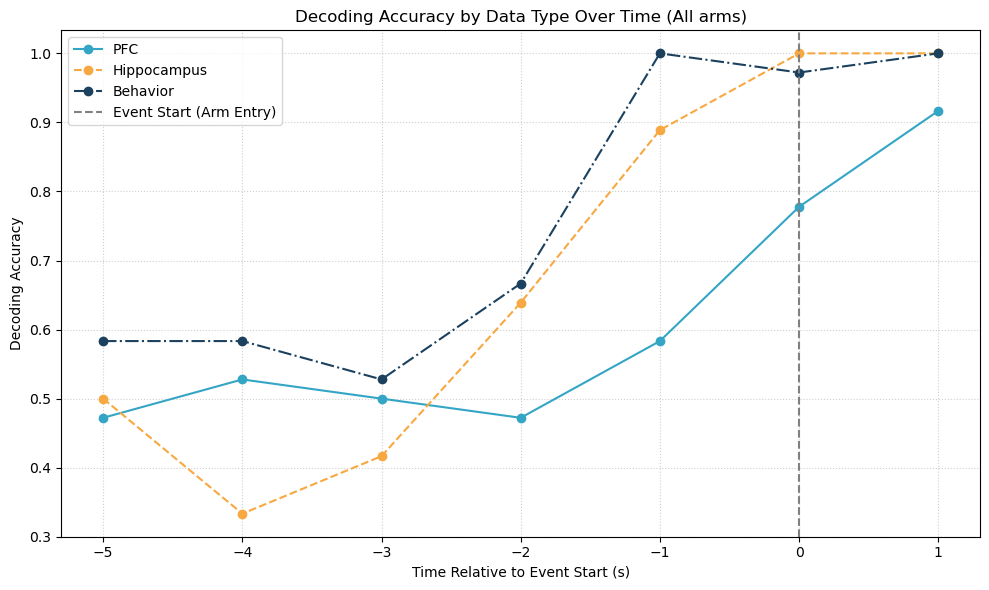

In [20]:
# Plots
plt.figure(figsize=(10, 6))
plt.plot(df_results["window_mid_s"], df_results["accuracy_pfc"],
         label="PFC", marker="o", linestyle="-", color="#34a5c5")
plt.plot(df_results["window_mid_s"], df_results["accuracy_hp"],
         label="Hippocampus", marker="o", linestyle="--", color="#f7a840")
plt.plot(df_results["window_mid_s"], df_results["accuracy_beh"],
         label="Behavior", marker="o", linestyle="-.", color="#1b415e")

# Add vertical line on event start time (t=0)
plt.axvline(x=0, color='gray', linestyle='--', linewidth=1.5, label="Event Start (Arm Entry)")

plt.title("Decoding Accuracy by Data Type Over Time (All arms)")
plt.xlabel("Time Relative to Event Start (s)")
plt.ylabel("Decoding Accuracy")
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()
plt.show()

In [18]:
# Load 'event_intervals_ms_rewarded' from a pickle file named 'decoding_data.pkl'
import os
import pickle

# Accept either 'decoding_data.pkl' or 'decoding_data' (without extension)
CANDIDATES = ["decoding_data.pkl", "decoding_data"]

src = next((p for p in CANDIDATES if os.path.exists(p) and os.path.isfile(p)), None)
if src is None:
    raise FileNotFoundError("File not found 'decoding_data.pkl' (or 'decoding_data').")

with open(src, "rb") as f:
    data = pickle.load(f)

if "event_intervals_ms_rewarded" not in data:
    raise KeyError(f"'event_intervals_ms_rewarded' not in {src}. "
                   f"Available keys: {list(data.keys())[:10]}{'...' if len(data)>=10 else ''}")

# Assign with the same variable name
event_intervals_ms_rewarded = data["event_intervals_ms_rewarded"]

try:
    n = len(event_intervals_ms_rewarded)
except Exception:
    n = "N/A"
print(f"Loaded 'event_intervals_ms_rewarded' with {src} (len={n})")


df_results_rew = run_sliding_window_decoding1(activity_matrix_pfc=mat_100pp_spikefiltered, activity_matrix_hp=mat_100hp_spikefiltered, lwhl=lwhl, event_intervals_ms=event_intervals_ms_rewarded,
    arm_ids=event_arm_ids_rewarded, sliding_windows_ms=windows_ms, bin_size_ms=100.0, min_spikes=100, verbose=False)

[INFO] [Split 0] TRAIN+VAL=101, GAP=5, TEST=26 (frac=0.20).


Loaded 'event_intervals_ms_rewarded' with decoding_data.pkl (len=133)


[INFO] [Split 0] TRAIN+VAL=101, GAP=5, TEST=26 (frac=0.20).
[INFO] [Split 0] TRAIN+VAL=101, GAP=5, TEST=26 (frac=0.20).
[INFO] [Split 0] TRAIN+VAL=101, GAP=5, TEST=26 (frac=0.20).
[INFO] [Split 0] TRAIN+VAL=101, GAP=5, TEST=26 (frac=0.20).
[INFO] [Split 0] TRAIN+VAL=101, GAP=5, TEST=26 (frac=0.20).
[INFO] [Split 0] TRAIN+VAL=101, GAP=5, TEST=26 (frac=0.20).
[INFO] [Split 0] TRAIN+VAL=101, GAP=5, TEST=26 (frac=0.20).
[INFO] [Split 0] TRAIN+VAL=101, GAP=5, TEST=26 (frac=0.20).
[INFO] [Split 0] TRAIN+VAL=101, GAP=5, TEST=26 (frac=0.20).
[INFO] [Split 0] TRAIN+VAL=101, GAP=5, TEST=26 (frac=0.20).
[INFO] [Split 0] TRAIN+VAL=101, GAP=5, TEST=26 (frac=0.20).
[INFO] [Split 0] TRAIN+VAL=101, GAP=5, TEST=26 (frac=0.20).
[INFO] [Split 0] TRAIN+VAL=101, GAP=5, TEST=26 (frac=0.20).
[INFO] [Split 0] TRAIN+VAL=101, GAP=5, TEST=26 (frac=0.20).
[INFO] [Split 0] TRAIN+VAL=101, GAP=5, TEST=26 (frac=0.20).
[INFO] [Split 0] TRAIN+VAL=101, GAP=5, TEST=26 (frac=0.20).
[INFO] [Split 0] TRAIN+VAL=101, GAP=5, T

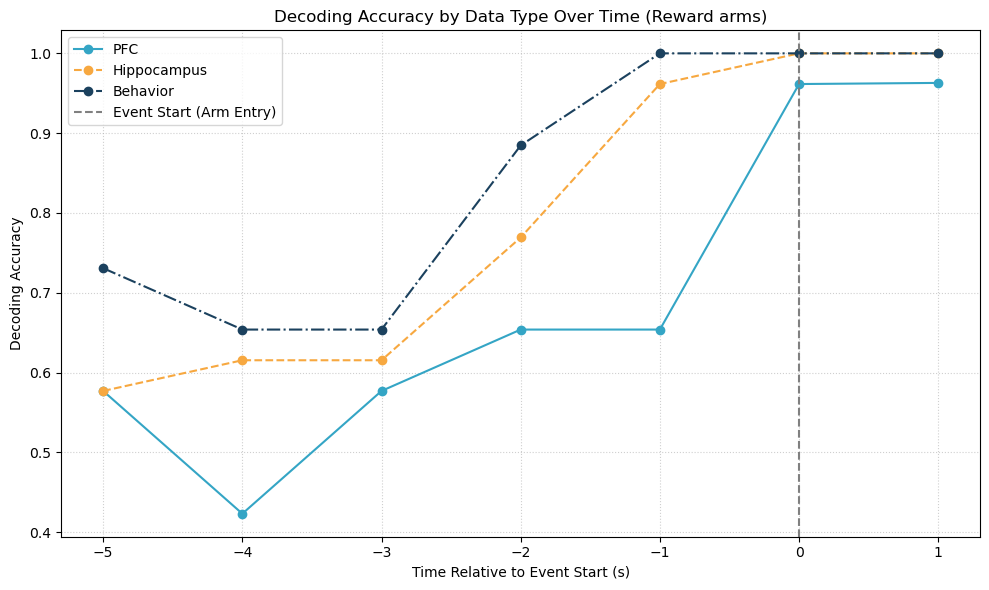

In [21]:
# Plots
plt.figure(figsize=(10, 6))
plt.plot(df_results_rew["window_mid_s"], df_results_rew["accuracy_pfc"],
         label="PFC", marker="o", linestyle="-", color="#34a5c5")
plt.plot(df_results_rew["window_mid_s"], df_results_rew["accuracy_hp"],
         label="Hippocampus", marker="o", linestyle="--", color="#f7a840")
plt.plot(df_results_rew["window_mid_s"], df_results_rew["accuracy_beh"],
         label="Behavior", marker="o", linestyle="-.", color="#1b415e")

# Add vertical line on event start time (t=0)
plt.axvline(x=0, color='gray', linestyle='--', linewidth=1.5, label="Event Start (Arm Entry)")

plt.title("Decoding Accuracy by Data Type Over Time (Reward arms)")
plt.xlabel("Time Relative to Event Start (s)")
plt.ylabel("Decoding Accuracy")
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()
plt.show()

In [22]:
def select_rewarded_arms(tensor, event_arm_ids,reward_arms, dim_events):

    import numpy as np
    
    event_arm_ids = np.array(event_arm_ids)
    reward_arms = np.array(reward_arms)
    
    # Create boolean mask: True if the event corresponds to a rewarded arm
    mask_rewarded = np.isin(event_arm_ids, reward_arms)
    
    # Apply mask to the tensor and to the arm IDs
    if dim_events==1:
        tensor_rewarded = tensor[:, mask_rewarded, :]

    if dim_events==2:
        tensor_rewarded = tensor[:, :, mask_rewarded]
    
    event_arm_ids_rewarded = event_arm_ids[mask_rewarded]
    
    print(f"Total number of events: {len(event_arm_ids)}")
    print(f"Number of events in reward arms: {len(event_arm_ids_rewarded)}")
    
    print(tensor_rewarded.shape)
    print(event_arm_ids_rewarded)
    
    return tensor_rewarded, event_arm_ids_rewarded

In [23]:
import numpy as np

def extract_window_relative_to_event_end(neural_binned, event_intervals_ms, *, window_start_ms, window_end_ms,
    bin_size_ms=100.0, session_start_ms=0.0, on_short="pad", pad_value=0.0,):
    """
    Builds a neural tensor for a fixed window relative to the END of each event:
    [event_end + window_start, event_end + window_end).

    This function is useful for analyzing post-event activity, such as neural
    dynamics after an animal leaves a specific arm.

    Parameters
    ----------
    neural_binned : np.ndarray
        Binned neural activity, with shape (neurons, session_bins).
    event_intervals_ms : list of tuples
        A list of (start_ms, end_ms) for each event. The 'end_ms' is used
        as the temporal reference point.
    window_start_ms : float
        The start offset of the window in milliseconds, relative to the event's end.
    window_end_ms : float
        The end offset of the window in milliseconds, relative to the event's end.
    bin_size_ms : float, optional
        Size of time bins in milliseconds. Default is 100.0.
    session_start_ms : float, optional
        Start time of the recording session in milliseconds. Default is 0.0.
    on_short : str, optional
        How to handle segments shorter than the window. "pad" (default) fills
        with pad_value, "drop" discards the event.
    pad_value : float, optional
        Value to use for padding short segments. Default is 0.0.

    Returns
    -------
    tuple
        A tuple containing:
        - tensor (np.ndarray): The 3D tensor of neural activity (neurons, T_bins, n_events).
        - kept (np.ndarray): A boolean mask indicating which events were kept.
        - t_rel_ms (np.ndarray): A 1D array of relative time points for the bins.
    """
    if neural_binned.ndim != 2:
        raise ValueError("neural_binned must be 2D (neurons, session_bins).")
    n_neurons, T_session = neural_binned.shape
    win_ms = float(window_end_ms) - float(window_start_ms)
    T_bins = int(round(win_ms / float(bin_size_ms)))
    if T_bins < 1:
        raise ValueError(f"Window duration ({win_ms}ms) must be >= 1 bin ({bin_size_ms}ms).")

    # Ideal bin centers, now relative to the end of the event
    t_rel_ms = (float(window_start_ms) + (np.arange(T_bins) + 0.5) * float(bin_size_ms))

    kept, slices = [], []
    # Key change: We loop over the event intervals and use the event_end_ms as the reference
    for (_event_start_ms_unused, event_end_ms) in event_intervals_ms:
        take_start_ms = float(event_end_ms) + float(window_start_ms)
        take_end_ms = float(event_end_ms) + float(window_end_ms)
        
        start_bin = int(np.floor((take_start_ms - session_start_ms) / bin_size_ms))
        end_bin = int(np.floor((take_end_ms - session_start_ms) / bin_size_ms))

        # Clip to session bounds
        seg_avail = neural_binned[:, max(start_bin, 0) : min(end_bin, T_session)]
        width_avail = seg_avail.shape[1]

        if width_avail >= T_bins:
            # Keep the segment of correct width (no padding needed)
            seg = seg_avail[:, :T_bins]
        else:
            # Handle short segments
            if on_short == "drop":
                kept.append(False)
                continue
            seg = np.full((n_neurons, T_bins), float(pad_value), dtype=float)
            seg[:, :width_avail] = seg_avail

        slices.append(seg.astype(float, copy=False))
        kept.append(True)

    kept = np.asarray(kept, dtype=bool)
    tensor = np.stack(slices, axis=-1) if len(slices) else np.empty((n_neurons, T_bins, 0), dtype=float)
    return tensor, kept, t_rel_ms

In [24]:
def filter_events_by_arm_id(event_matrices, arm_ids, target_arm_id):
    """
    Filters a list of event matrices and their corresponding arm IDs, keeping
    only those that match a specific target arm ID.

    Parameters
    ----------
    event_matrices : list of np.ndarray
        A list of event matrices, where each matrix represents one event.
    arm_ids : np.ndarray
        An array of arm IDs corresponding to each event matrix.
    target_arm_id : int or str
        The specific arm ID to filter for.

    Returns
    -------
    tuple
        A tuple containing:
        - filtered_matrices (list): The list of matrices for the target arm.
        - filtered_ids (np.ndarray): The array of IDs for the filtered matrices.
    """
    filtered_matrices = []
    filtered_ids = []
    
    for i, arm_id in enumerate(arm_ids):
        if arm_id == target_arm_id:
            filtered_matrices.append(event_matrices[i])
            filtered_ids.append(arm_id)
            
    return filtered_matrices, np.array(filtered_ids)

In [28]:
# Sliding-window BIN-wise decoding (grouped by event, no leakage)

import numpy as np
import pandas as pd
import logging
from dataclasses import dataclass

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score

# statistical utilities 
def _wilson_ci(k, n, alpha=0.05):
    if n == 0: return (np.nan, np.nan)
    from scipy.stats import norm
    z = norm.ppf(1 - alpha/2)
    phat = k / n
    denom = 1 + z**2/n
    centre = phat + z*z/(2*n)
    adj = z * np.sqrt((phat*(1-phat) + z*z/(4*n))/n)
    lower = (centre - adj)/denom
    upper = (centre + adj)/denom
    return float(lower), float(upper)

def _bootstrap_ci_macro_f1(y_true, y_pred, B=1000, alpha=0.05, rng=None):
    rng = np.random.RandomState(0) if rng is None else rng
    n = len(y_true)
    if n == 0: return (np.nan, np.nan)
    vals = []
    y_true = np.asarray(y_true); y_pred = np.asarray(y_pred)
    for _ in range(B):
        idx = rng.randint(0, n, n)
        vals.append(f1_score(y_true[idx], y_pred[idx], average="macro"))
    lo, hi = np.percentile(vals, [100*alpha/2, 100*(1-alpha/2)])
    return float(lo), float(hi)

def _perm_pvalue_acc(y_true, y_pred, n_perm=1000, rng=None):
    """Simple permutation on test labels vs fixed predictions (bin-level)."""
    rng = np.random.RandomState(0) if rng is None else rng
    acc_real = float(accuracy_score(y_true, y_pred))
    cnt = 0
    for _ in range(int(n_perm)):
        if accuracy_score(rng.permutation(y_true), y_pred) >= acc_real:
            cnt += 1
    pval = (cnt + 1) / (n_perm + 1)
    return acc_real, float(pval)

# ---------- Shape helpers ----------
def _tensor_to_event_mats_fallback(t3):
    """
    (channels, events, T) -> list of per-event matrices (channels, T).
    Used if you don't have your own `tensor_to_event_mats`.
    """
    if not isinstance(t3, np.ndarray) or t3.ndim != 3:
        raise ValueError("Expected a 3D tensor shaped (channels, events, T).")
    C, E, T = t3.shape
    return [t3[:, i, :] for i in range(E)]

def _resize_time_to_T(M, T, how="interp"):
    """
    Resize per-event matrix (features, T_old) to (features, T) for alignment.
    Use 'interp' for behavior to match the 100ms bin count of neural windows.
    """
    n, t = M.shape
    if t == T: return M
    if how == "interp":
        src = np.linspace(0, t-1, t); dst = np.linspace(0, t-1, T)
        out = np.empty((n, T), float)
        for i in range(n): out[i] = np.interp(dst, src, M[i])
        return out
    if how == "pad":
        out = np.zeros((n, T), float); take = min(t, T); out[:, :take] = M[:, :take]; return out
    if how == "truncate":
        return M[:, :min(t, T)]
    raise ValueError("how must be 'interp' | 'pad' | 'truncate'.")

def _expand_events_to_bin_list(event_mats):
    """
    Input:  list of per-event matrices (channels, T)
    Output: list of per-bin matrices (channels, 1), event_index[], bin_index[]
    """
    bin_mats, ev_idx, bin_idx = [], [], []
    for ei, M in enumerate(event_mats):
        n, T = M.shape
        for b in range(T):
            bin_mats.append(M[:, b:b+1])
            ev_idx.append(ei)
            bin_idx.append(b)
    return bin_mats, np.asarray(ev_idx, int), np.asarray(bin_idx, int)

def _build_X_from_bin_mats(bin_mats):
    """Stack list of (channels,1) into design matrix (n_bins, channels)."""
    return np.stack([m.reshape(-1) for m in bin_mats], axis=0)

# ---------- Bin-wise RF grouped by EVENT (no leakage across bins) ----------
@dataclass
class BinwiseResult:
    best_params: dict
    cv_metrics: dict
    test_metrics: dict
    test_ci: dict
    counts: dict  # sizes in events and bins

def _rf_binwise_grouped_by_event(event_mats_list,
    y_events,         # labels per event
    *, holdout_frac=0.20,
    gap_events=1,     # buffer in events between TR/VAL and TEST
    n_blocks_inner=3,        # CV blocks over EVENTS
    param_grid=None, pca_dims=None,
    n_perm_test=2000, random_state=42, verbose=False):
    log = logging.getLogger("binwise_rf")
    if verbose:
        log.setLevel(logging.INFO)
        if not log.handlers:
            h = logging.StreamHandler()
            h.setFormatter(logging.Formatter("[%(levelname)s] %(message)s"))
            log.addHandler(h)
    else:
        log.setLevel(logging.WARNING)

    events = list(event_mats_list)
    y_events = np.asarray(y_events, int)
    N_events = len(events)
    if N_events != len(y_events):
        raise ValueError("Length of y_events must match number of events.")

    # Expand to bin-level but keep mapping to events
    bin_mats, ev_idx, bin_idx = _expand_events_to_bin_list(events)
    y_bins = y_events[ev_idx]

    # Blocked holdout at EVENT level (with gap)
    n_test_events = max(1, int(round(holdout_frac * N_events)))
    n_trval_events = max(2, N_events - n_test_events - int(gap_events))
    if n_trval_events < 2:
        raise ValueError("Not enough events after holdout+gap to train/validate.")
    ev_trval = np.arange(0, n_trval_events)
    ev_gap   = np.arange(n_trval_events, n_trval_events + int(gap_events))
    ev_test  = np.arange(n_trval_events + int(gap_events), N_events)

    mask_tr = np.isin(ev_idx, ev_trval)
    mask_te = np.isin(ev_idx, ev_test)

    # Inner CV over EVENTS (blocked)
    n_blocks_eff = int(max(2, min(n_blocks_inner, len(ev_trval))))
    edges = np.linspace(0, len(ev_trval), n_blocks_eff+1, dtype=int)
    ev_blocks = [ev_trval[edges[i]:edges[i+1]] for i in range(n_blocks_eff) if edges[i] < edges[i+1]]

    # Mini RF grid
    if param_grid is None:
        param_grid = [
            {"n_estimators": ne, "max_depth": md, "min_samples_leaf": msl, "max_features": mf}
            for ne in [200, 400]
            for md in [None, 20]
            for msl in [1, 2]
            for mf in ["sqrt", 0.5]]

    scores_per_param = [[] for _ in param_grid]

    for ev_te in ev_blocks:
        ev_tr = np.setdiff1d(ev_trval, ev_te, assume_unique=True)
        mtr = np.isin(ev_idx, ev_tr)
        mte = np.isin(ev_idx, ev_te)

        X_tr = _build_X_from_bin_mats([m for m, k in zip(bin_mats, mtr) if k])
        X_te = _build_X_from_bin_mats([m for m, k in zip(bin_mats, mte) if k])
        y_tr, y_te = y_bins[mtr], y_bins[mte]

        scaler = StandardScaler().fit(X_tr)
        X_tr_s = scaler.transform(X_tr); X_te_s = scaler.transform(X_te)

        if pca_dims is not None:
            n_comp = int(min(pca_dims, X_tr_s.shape[0], X_tr_s.shape[1]))
            if n_comp >= 1:
                pca = PCA(n_components=n_comp, random_state=random_state).fit(X_tr_s)
                X_tr_s = pca.transform(X_tr_s); X_te_s = pca.transform(X_te_s)

        for pi, params in enumerate(param_grid):
            rf = RandomForestClassifier(**params, class_weight="balanced",
                                        random_state=random_state, n_jobs=-1).fit(X_tr_s, y_tr)
            yhat = rf.predict(X_te_s)
            scores_per_param[pi].append(accuracy_score(y_te, yhat))

    means = [np.mean(s) if len(s) else np.nan for s in scores_per_param]
    best_idx = int(np.nanargmax(means))
    best_params = param_grid[best_idx]

    # Train on all TR+VAL bins, evaluate on TEST bins
    X_trval = _build_X_from_bin_mats([m for m, k in zip(bin_mats, mask_tr) if k])
    X_test  = _build_X_from_bin_mats([m for m, k in zip(bin_mats, mask_te) if k])
    y_trval, y_test = y_bins[mask_tr], y_bins[mask_te]

    scaler = StandardScaler().fit(X_trval)
    X_trval_s = scaler.transform(X_trval); X_test_s = scaler.transform(X_test)

    if pca_dims is not None:
        n_comp = int(min(pca_dims, X_trval_s.shape[0], X_trval_s.shape[1]))
        if n_comp >= 1:
            pca = PCA(n_components=n_comp, random_state=random_state).fit(X_trval_s)
            X_trval_s = pca.transform(X_trval_s); X_test_s = pca.transform(X_test_s)

    rf_final = RandomForestClassifier(**best_params, class_weight="balanced",
                                      random_state=random_state, n_jobs=-1).fit(X_trval_s, y_trval)
    yhat = rf_final.predict(X_test_s)

    # Bin-level metrics
    acc = float(accuracy_score(y_test, yhat))
    bal = float(balanced_accuracy_score(y_test, yhat))
    mf1 = float(f1_score(y_test, yhat, average="macro"))
    wf1 = float(f1_score(y_test, yhat, average="weighted"))
    k_correct = int((y_test == yhat).sum()); n_eval = int(len(y_test))
    acc_lo, acc_hi = _wilson_ci(k_correct, n_eval, alpha=0.05)
    mf1_lo, mf1_hi = _bootstrap_ci_macro_f1(y_test, yhat, B=2000, alpha=0.05)

    # Permutation p-value at bin-level (labels shuffled)
    _, p_perm = _perm_pvalue_acc(y_test, yhat, n_perm=n_perm_test, rng=np.random.RandomState(random_state))

    res = BinwiseResult(
        best_params=best_params,
        cv_metrics={"cv_mean_acc": float(np.nanmax(means))},
        test_metrics={"accuracy": acc, "balanced_accuracy": bal, "macro_f1": mf1, "weighted_f1": wf1, "perm_pvalue": p_perm},
        test_ci={"accuracy_wilson": (acc_lo, acc_hi), "macro_f1_bootstrap": (mf1_lo, mf1_hi), "n_test_bins": n_eval},
        counts={"n_events_trval": int(len(ev_trval)), "n_events_test": int(len(ev_test)),
                "n_bins_trval": int(mask_tr.sum()), "n_bins_test": int(mask_te.sum())})
    if verbose:
        log.info(f"Events TR+VAL={res.counts['n_events_trval']} (bins={res.counts['n_bins_trval']}), "
                 f"TEST={res.counts['n_events_test']} (bins={res.counts['n_bins_test']})")
        log.info(f"Best params: {best_params}")
        log.info(f"TEST (bin): acc={acc:.3f} [{acc_lo:.3f},{acc_hi:.3f}], "
                 f"bal={bal:.3f}, macroF1={mf1:.3f} [{mf1_lo:.3f},{mf1_hi:.3f}], p_perm={p_perm:.3f}")
    return res

# ---------- Sliding-window orchestrator (BIN-wise) ----------
def run_sliding_window_decoding_bins(activity_matrix_pfc,
    activity_matrix_hp, lwhl,
    previous_event_intervals,     # list[(start_ms, end_ms)] of the PREVIOUS event
    arm_ids_to_predict,           # labels of the NEXT event (multi/binary)
    *,
    sliding_windows_ms,           # list[(start_offset_ms, end_offset_ms)] w.r.t. PREV END
    bin_size_ms=100.0, session_start_ms=0.0, fs_hz=39.0625,
    # window/data guards
    min_events_total=30, min_per_class=3,
    # decoder knobs
    gap_events=1, n_blocks_inner=3, pca_dims=None,
    n_perm_test=2000, random_state=42, verbose=False):
    """
    For each time window, extracts neural and behavior windows anchored to the END of the previous event,
    converts each 100ms BIN into a separate training example (with the event's label), and trains a
    classifier with event-grouped splits to avoid leakage. Returns a tidy DataFrame with bin-level metrics.
    """
    log = logging.getLogger("run_sw_bins")
    if verbose:
        log.setLevel(logging.INFO)
        if not log.handlers:
            h = logging.StreamHandler()
            h.setFormatter(logging.Formatter("[%(levelname)s] %(message)s"))
            log.addHandler(h)
    else:
        log.setLevel(logging.WARNING)

    # Prefer user's converter if present
    _tensor_to_mats = globals().get("tensor_to_event_mats", _tensor_to_event_mats_fallback)

    prev_int = list(previous_event_intervals)
    y_all = np.asarray(arm_ids_to_predict, int)
    if len(prev_int) != len(y_all):
        raise ValueError("previous_event_intervals and arm_ids_to_predict must have the same length.")

    rows = []
    for start_ms, end_ms in sliding_windows_ms:
        if verbose:
            log.info(f"\nWindow [{start_ms/1000:.1f}, {end_ms/1000:.1f}] s (relative to PREVIOUS END)")

        # --- PFC and HP: extractor already relative to PREVIOUS END ---
        t_pfc, kept_pfc, _ = extract_window_relative_to_event_end(neural_binned=activity_matrix_pfc,
            event_intervals_ms=prev_int,
            bin_size_ms=bin_size_ms,
            window_start_ms=start_ms, window_end_ms=end_ms,
            session_start_ms=session_start_ms, on_short="pad", pad_value=0.0)
        
        t_hp, kept_hp, _ = extract_window_relative_to_event_end(neural_binned=activity_matrix_hp,
            event_intervals_ms=prev_int,
            bin_size_ms=bin_size_ms, window_start_ms=start_ms, window_end_ms=end_ms,
            session_start_ms=session_start_ms,
            on_short="pad", pad_value=0.0)

        # Window bin count (must match both neural tensors)
        if t_pfc.ndim != 3 or t_hp.ndim != 3:
            raise ValueError("Neural extractors must return tensors shaped (neurons, events, T_bins).")
        T_bins = t_pfc.shape[2]
        if t_hp.shape[2] != T_bins:
            raise ValueError("PFC and HP tensors have different T_bins for this window.")

        # --- Behavior: anchor to PREVIOUS END, then resize per-event to T_bins ---
        beh_intervals = [(e + start_ms, e + end_ms) for (s, e) in prev_int]
        beh_list, kept_beh, _, _ = construct_behavior_matrices_from_whl_polar(whl=lwhl,
            event_intervals_ms=beh_intervals, fs_hz=fs_hz, min_points=3,
            clip_to_whl=True, center=None, add_derivatives=True)

        kept_pfc = np.asarray(kept_pfc, bool)
        kept_hp  = np.asarray(kept_hp, bool)
        kept_beh = np.asarray(kept_beh, bool)

        # Common events across modalities
        final_mask = kept_pfc & kept_hp & kept_beh
        n_events = int(final_mask.sum())
        if n_events == 0:
            if verbose: log.warning("No aligned events across modalities. Skipping window.")
            continue

        # Build per-event matrices (channels, T_bins) and align labels
        mats_pfc = [m for m, k in zip(_tensor_to_mats(t_pfc), final_mask) if k]
        mats_hp  = [m for m, k in zip(_tensor_to_mats(t_hp),  final_mask) if k]

        # Resize behavior events to T_bins (linear interp)
        mats_beh = []
        for mat, k in zip(beh_list, final_mask):
            if not k or mat is None: continue
            mats_beh.append(_resize_time_to_T(mat, T_bins, how="interp"))

        y = y_all[final_mask]

        # --- Guards per window (multi- or binary-class) ---
        if n_events < int(min_events_total):
            if verbose: log.warning(f"Too few events after alignment ({n_events}<{min_events_total}). Skipping.")
            continue
        classes = np.unique(y)
        if classes.size < 2:
            if verbose: log.warning("Only one class present. Skipping window.")
            continue
        counts = {int(c): int((y == c).sum()) for c in classes}
        if min(counts.values()) < int(min_per_class):
            if verbose: log.warning(f"Too few per-class samples {counts} (<{min_per_class}). Skipping.")
            continue

        # --- Decode per modality (bin-wise, grouped by event) ---
        dec_kwargs = dict(holdout_frac=0.20,
            gap_events=gap_events, n_blocks_inner=n_blocks_inner,
            pca_dims=pca_dims, n_perm_test=n_perm_test,
            random_state=random_state, verbose=False)

        try:
            res_pfc = _rf_binwise_grouped_by_event(mats_pfc, y, **dec_kwargs)
            res_hp  = _rf_binwise_grouped_by_event(mats_hp,  y, **dec_kwargs)
            res_beh = _rf_binwise_grouped_by_event(mats_beh, y, **dec_kwargs)
        except Exception as e:
            if verbose: log.warning(f"Decoder failed on this window: {e}")
            continue

        def _pack(prefix, res):
            acc_lo, acc_hi = res.test_ci.get("accuracy_wilson", (np.nan, np.nan))
            mf1_lo, mf1_hi = res.test_ci.get("macro_f1_bootstrap", (np.nan, np.nan))
            return {f"{prefix}_accuracy":          res.test_metrics.get("accuracy", np.nan),
                f"{prefix}_balanced_accuracy": res.test_metrics.get("balanced_accuracy", np.nan),
                f"{prefix}_macro_f1":          res.test_metrics.get("macro_f1", np.nan),
                f"{prefix}_weighted_f1":       res.test_metrics.get("weighted_f1", np.nan),
                f"{prefix}_acc_lo":            acc_lo, f"{prefix}_acc_hi": acc_hi,
                f"{prefix}_mf1_lo":            mf1_lo, f"{prefix}_mf1_hi": mf1_hi,
                f"{prefix}_perm_pvalue":       res.test_metrics.get("perm_pvalue", np.nan),
                f"{prefix}_n_bins_test":       res.test_ci.get("n_test_bins", np.nan),}

        row = {"window_start_s": float(start_ms) / 1000.0, "window_mid_s":   float(start_ms + end_ms) / 2000.0,
            "n_events_used": n_events, "class_counts": counts}
        row.update(_pack("pfc", res_pfc))
        row.update(_pack("hp",  res_hp))
        row.update(_pack("beh", res_beh))
        rows.append(row)

    if not rows:
        return pd.DataFrame()

    return pd.DataFrame(rows).sort_values("window_start_s").reset_index(drop=True)

In [29]:
import numpy as np
import pandas as pd

def build_transitions(arm_ids, event_intervals_ms, *, mode="all", from_set=None, to_set=None):
    """
    Construye:
      - previous_event_intervals: intervalos del evento PREVIO (i-1)
      - arm_ids_to_predict: etiqueta del evento ACTUAL (i)
      - trans_df: dataframe con todas las transiciones prev->curr (útil para inspección)
    mode:
      - "all": usa todas las transiciones consecutivas
      - "from2_to_48": solo prev==2 y curr in {4,8}
      - "custom": usa from_set (set/list) y to_set (set/list)
    """
    arm_ids = np.asarray(arm_ids)
    assert len(arm_ids) == len(event_intervals_ms), "arm_ids y event_intervals_ms deben tener misma longitud."

    prev_idx = np.arange(1, len(arm_ids)) - 1
    curr_idx = np.arange(1, len(arm_ids))
    prev_arm = arm_ids[prev_idx]
    curr_arm = arm_ids[curr_idx]

    data = {"prev_idx": prev_idx,
        "curr_idx": curr_idx,
        "prev_arm": prev_arm,
        "curr_arm": curr_arm,
        "prev_interval_ms": [event_intervals_ms[i] for i in prev_idx],
        "curr_interval_ms": [event_intervals_ms[i] for i in curr_idx],}
    trans_df = pd.DataFrame(data)

    if mode == "all":
        mask = np.ones(len(trans_df), dtype=bool)
    elif mode == "from2_to_48":
        mask = (trans_df["prev_arm"] == 2) & (trans_df["curr_arm"].isin([4, 8]))
    elif mode == "custom":
        if from_set is None or to_set is None:
            raise ValueError("Para mode='custom' proporciona from_set y to_set.")
        mask = trans_df["prev_arm"].isin(set(from_set)) & trans_df["curr_arm"].isin(set(to_set))
    else:
        raise ValueError("mode debe ser 'all' | 'from2_to_48' | 'custom'.")

    sub = trans_df[mask].reset_index(drop=True)

    previous_event_intervals = list(sub["prev_interval_ms"])
    arm_ids_to_predict = list(sub["curr_arm"])

    # Resumen y checks
    counts = (sub.value_counts(["prev_arm", "curr_arm"])
        .rename("count")
        .reset_index()
        .sort_values(["prev_arm","curr_arm"])
        .reset_index(drop=True))

    print(f"Selected transitions: {len(sub)}")
    print(counts if len(counts) else "No transitions after the filter.")
    assert len(previous_event_intervals) == len(arm_ids_to_predict)

    return previous_event_intervals, np.array(arm_ids_to_predict, dtype=int), sub

# MODE A: ALL consecutive transitions (multi-class)
previous_event_intervals, arm_ids_to_predict, trans_df_sel = build_transitions(arm_ids=event_arm_ids, event_intervals_ms=event_intervals_ms, mode="all")

# # MODE B: Only 2 → {4,8} (binary). Uncomment if you want this filter:
# previous_event_intervals, arm_ids_to_predict_raw, trans_df_sel = build_transitions(
#     arm_ids=arm_ids,
#     event_intervals_ms=event_intervals_ms,
#     mode="from2_to_48"
# )
# # if you want to map to {0,1}:
# arm_id_map = {4:0, 8:1}
# arm_ids_to_predict = np.array([arm_id_map[a] for a in arm_ids_to_predict_raw], dtype=int)

# # MODE C: Custom (e.g., {4,8}→{2,4,8}). Uncomment and adjust:
# previous_event_intervals, arm_ids_to_predict, trans_df_sel = build_transitions(
#     arm_ids=arm_ids,
#     event_intervals_ms=event_intervals_ms,
#     mode="custom",
#     from_set=[4,8],
#     to_set=[2,4,8]
# )

# Quick view (first 8)
# try:
#     display(trans_df_sel.head(8))
# except:
#     print(trans_df_sel.head(8))

Selected transitions: 179
    prev_arm  curr_arm  count
0          1         1      1
1          1         2      7
2          1         3      5
3          1         4      5
4          1         5      1
5          1         8      1
6          2         1      3
7          2         2      1
8          2         3      1
9          2         4     24
10         2         5      3
11         2         6      1
12         2         7      1
13         2         8     13
14         3         1      2
15         3         4      2
16         3         5      2
17         3         8      3
18         4         1      4
19         4         2     10
20         4         3      1
21         4         4      1
22         4         5      1
23         4         6      2
24         4         7      2
25         4         8     17
26         5         1      1
27         5         2      1
28         5         7      1
29         5         8      5
30         6         1      1
31         6  

In [ ]:
windows_ms = [(-4000, -2000),(-2000, 0), (0, 2000),(2000, 4000),(4000,6000)]  # for example, 2 s windows -> 20 bins if bin_size_ms=100
df_bins = run_sliding_window_decoding_bins(activity_matrix_pfc = mat_100pp_spikefiltered,
    activity_matrix_hp  = mat_100hp_spikefiltered, lwhl = lwhl,
    previous_event_intervals = previous_event_intervals,  # intervals of the PREVIOUS event
    arm_ids_to_predict = arm_ids_to_predict,  # labels of the NEXT event
    sliding_windows_ms = windows_ms,
    bin_size_ms = 100.0, session_start_ms = 0.0,
    fs_hz = 39.0625, min_events_total = 30, min_per_class = 3,
    gap_events = 1, n_blocks_inner = 4, pca_dims = None,
    n_perm_test = 3000, random_state = 42, verbose = True)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Temporal order
dfp = df_bins.sort_values("window_mid_s").reset_index(drop=True).copy()

# Chance per window (1 / n_classes); if class_counts is dict per row:
def _chance_from_counts(cc):
    try:
        ncls = len(cc) if isinstance(cc, dict) else np.nan
        return 1.0 / ncls if ncls and ncls > 0 else np.nan
    except Exception:
        return np.nan

dfp["chance"] = dfp["class_counts"].apply(_chance_from_counts)

# Plot 1: Accuracy + Wilson IC
plt.figure(figsize=(10, 6))
series = [("pfc", "PFC", "-",  "#34a5c5"),
    ("hp",  "Hippocampus", "--", "#f7a840"),
    ("beh", "Behavior", "-.", "#1b415e"),]

x = dfp["window_mid_s"].values
# Chance line (if it varies per window, draw a discontinuous curve)
if np.isfinite(dfp["chance"]).any():
    plt.plot(x, dfp["chance"].values, linestyle=":", color="gray", label="Chance")

for key, label, ls, color in series:
    y  = dfp.get(f"{key}_accuracy", pd.Series(np.nan, index=dfp.index)).values
    lo = dfp.get(f"{key}_acc_lo",   pd.Series(np.nan, index=dfp.index)).values
    hi = dfp.get(f"{key}_acc_hi",   pd.Series(np.nan, index=dfp.index)).values
    p  = dfp.get(f"{key}_perm_pvalue", pd.Series(np.nan, index=dfp.index)).values

    plt.plot(x, y, marker="o", linestyle=ls, color=color, label=label)
    # CI bands
    if np.isfinite(lo).any() and np.isfinite(hi).any():
        plt.fill_between(x, lo, hi, alpha=0.15, color=color)
    # mark significant ones
    sig = np.isfinite(p) & (p < 0.05)
    if sig.any():
        plt.scatter(x[sig], y[sig], marker="*", s=120, color=color, edgecolor="k", zorder=5)

plt.axvline(0, color="gray", linestyle="--", linewidth=1.5, label="t=0 (end of previous event)")
plt.title("Bin-wise decoding — Accuracy (with Wilson CI & p<0.05)")
plt.xlabel("Relative time to the end of previous event (s)")
plt.ylabel("Accuracy")
plt.grid(True, linestyle=":", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

# Plot 2: Macro-F1 + bootstrap CI
plt.figure(figsize=(10, 6))
for key, label, ls, color in series:
    y  = dfp.get(f"{key}_macro_f1", pd.Series(np.nan, index=dfp.index)).values
    lo = dfp.get(f"{key}_mf1_lo",   pd.Series(np.nan, index=dfp.index)).values
    hi = dfp.get(f"{key}_mf1_hi",   pd.Series(np.nan, index=dfp.index)).values
    p  = dfp.get(f"{key}_perm_pvalue", pd.Series(np.nan, index=dfp.index)).values

    plt.plot(x, y, marker="o", linestyle=ls, color=color, label=label)
    if np.isfinite(lo).any() and np.isfinite(hi).any():
        plt.fill_between(x, lo, hi, alpha=0.15, color=color)
    sig = np.isfinite(p) & (p < 0.05)
    if sig.any():
        plt.scatter(x[sig], y[sig], marker="*", s=120, color=color, edgecolor="k", zorder=5)

plt.axvline(0, color="gray", linestyle="--", linewidth=1.5)
plt.title("Bin-wise decoding — Macro-F1 (with IC bootstrap and p<0.05)")
plt.xlabel("Tiempo relativo al fin del evento previo (s)")
plt.ylabel("Macro-F1")
plt.grid(True, linestyle=":", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

[INFO] 
Window [-4.0, -2.0] s (relative to PREVIOUS END)


KeyboardInterrupt: 